In [3]:
# -*- coding: utf-8 -*-
from __future__ import division
import argparse
import bz2
from datetime import datetime
import os
import pickle
from logger import Logger

import atari_py
import numpy as np
import torch
from tqdm import trange

from agent import Agent
from env import Env
from sunrise_memory import ReplayMemory
from test import ensemble_test
from tqdm import tqdm

In [4]:
class DataObject:
    def __init__(self):
        self.seed = 123
        self.game = 'boxing'
        self.T_max = 100000
        self.num_ensemble = 5
        self.beta_mean = 0.5
        self.memory_capacity = 500000
        self.id = 'vae_sunrise'
        self.temperature = 10
        self.learn_start = 1600
        self.target_update = 2000
        self.replay_frequency = 1
        self.multi_step = 20
        self.discount = 0.99
        self.architecture = 'data-efficient'
        self.max_episode_length = int(108e3)
        self.history_length = 4
        self.atoms = 51
        self.V_min = -10
        self.V_max = 10
        self.batch_size = 32
        self.model = None
        self.hidden_size = 256
        self.noisy_std = 0.1
        self.evaluation_size = 12000
        self.learning_rate = 0.0001
        self.adam_eps = 1.5e-4
        self.priority_weight = 0.4
        self.priority_exponent = 0.5
        
        if torch.cuda.is_available():
            self.device = torch.device('cuda')
            torch.cuda.manual_seed(np.random.randint(1, 10000))
            torch.backends.cudnn.enabled = True
            torch.set_default_tensor_type('torch.FloatTensor')

In [36]:
# Environment
args = DataObject()
env = Env(args)
env.train()
action_space = env.action_space()

# Agent
dqn_list = []
for _ in range(args.num_ensemble):
    dqn = Agent(args, env)
    dqn_list.append(dqn)

# If a model is provided, and evaluate is fale, presumably we want to resume, so try to load memory
if args.model is not None and not args.evaluate:
    if not args.memory:
        raise ValueError('Cannot resume training without memory save path. Aborting...')
    elif not os.path.exists(args.memory):
        raise ValueError('Could not find memory file at {path}. Aborting...'.format(path=args.memory))
    mem = load_memory(args.memory, args.disable_bzip_memory)

else:
    mem = ReplayMemory(args, args.memory_capacity, args.beta_mean, args.num_ensemble)

priority_weight_increase = (1 - args.priority_weight) / (args.T_max - args.learn_start)

# Construct validation memory
val_mem = ReplayMemory(args, args.evaluation_size, args.beta_mean, args.num_ensemble)
T, done = 0, True
state_list = []
for i in tqdm(range(args.evaluation_size)):
    if done:
        state, done = env.reset(), False
    if i>5:
        next_state, _, done = env.step(np.random.randint(0, action_space))
        val_mem.append(state, 0, 0, done)
        state = next_state
        state_list.append(state)
        T += 1

100%|██████████| 12000/12000 [00:23<00:00, 514.01it/s]


In [ ]:
import torch
from torch.autograd import Variable
import numpy as np
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import torch.optim as optim
from torch import nn
import matplotlib.pyplot as plt


class Normal(object):
    def __init__(self, mu, sigma, log_sigma, v=None, r=None):
        self.mu = mu
        self.sigma = sigma  # either stdev diagonal itself, or stdev diagonal from decomposition
        self.logsigma = log_sigma
        dim = mu.get_shape()
        if v is None:
            v = torch.FloatTensor(*dim)
            if r is None:
                r = torch.FloatTensor(*dim)
                self.v = v
                self.r = r
                
                
class Encoder(torch.nn.Module):
    def __init__(self, H, D_out):
        super(Encoder, self).__init__()
        self.conv1 = torch.nn.Conv2dv(6, 6, 2, stride=1)
        self.linear1 = torch.nn.Linear(100, H)
        self.linear2 = torch.nn.Linear(H, D_out)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.linear1(x))
        return F.relu(self.linear2(x))
    
    
class Decoder(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        super(Decoder, self).__init__()
        self.conv1 = torch.nn.Conv2dv(6, 6, 2, stride=1)
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, 100)
    
    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = 
        return 
    
class VAE(torch.nn.Module):
    def __init__(self, encoder, decoder):
        super(VAE, self).__init__()
        self.latent_dim = 64
        self.encoder = encoder
        self.decoder = decoder
        self._enc_mu = torch.nn.Linear(1000, self.latent_dim)
        self._enc_log_sigma = torch.nn.Linear(1000, self.latent_dim)
    
    def _sample_latent(self, h_enc):
        """
        Return the latent normal sample z ~ N(mu, sigma^2)
        """
        mu = self._enc_mu(h_enc)
        log_sigma = self._enc_log_sigma(h_enc)
        sigma = torch.exp(log_sigma)
        std_z = torch.from_numpy(np.random.normal(0, 1, size=sigma.size())).float()
        
        self.z_mean = mu
        self.z_sigma = sigma
        return mu + sigma * Variable(std_z, requires_grad=False)  # Reparameterization trick
    
    def forward(self, state):
        h_enc = self.encoder(state)
        z = self._sample_latent(h_enc)
        return self.decoder(z)
    
def latent_loss(z_mean, z_stddev):
    mean_sq = z_mean * z_mean
    stddev_sq = z_stddev * z_stddev
    return 0.5 * torch.mean(mean_sq + stddev_sq - torch.log(stddev_sq) - 1)

input_dim = 57 * 50
batch_size = 32
encoder = Encoder(input_dim, 1000, 1000)
decoder = Decoder(64, 1000, input_dim)
vae = VAE(encoder, decoder)
criterion = nn.MSELoss()

optimizer = optim.Adam(vae.parameters(), lr=0.001)
l = None
for epoch in tqdm(range(6000)):
    idxs, states, actions, returns, next_states, nonterminals, weights, masks = val_mem.sample(32)
    inputs =  Variable(states[:,:,14:-13,17:-17].reshape((32*4,57*50)).cpu())
    optimizer.zero_grad()
    dec = vae(inputs)
    ll = latent_loss(vae.z_mean, vae.z_sigma)
    loss = criterion(dec, inputs) + ll
    loss.backward()
    optimizer.step()
    l = loss.item()
    
    print(epoch, l)
    
plt.imshow(vae(inputs).data[0].numpy().reshape(57, 50), cmap='gray')
plt.show(block=True)

In [5]:
args = DataObject()

In [6]:
# Environment
env = Env(args)
env.train()
action_space = env.action_space()

# Agent
dqn_list = []
for _ in range(args.num_ensemble):
    dqn = Agent(args, env)
    dqn_list.append(dqn)

# If a model is provided, and evaluate is fale, presumably we want to resume, so try to load memory
if args.model is not None and not args.evaluate:
    if not args.memory:
        raise ValueError('Cannot resume training without memory save path. Aborting...')
    elif not os.path.exists(args.memory):
        raise ValueError('Could not find memory file at {path}. Aborting...'.format(path=args.memory))
    mem = load_memory(args.memory, args.disable_bzip_memory)

else:
    mem = ReplayMemory(args, args.memory_capacity, args.beta_mean, args.num_ensemble)

priority_weight_increase = (1 - args.priority_weight) / (args.T_max - args.learn_start)

# Construct validation memory
val_mem = ReplayMemory(args, args.evaluation_size, args.beta_mean, args.num_ensemble)
T, done = 0, True
states = []
for i in tqdm(range(args.evaluation_size)):
    if done:
        state, done = env.reset(), False
    next_state, _, done = env.step(np.random.randint(0, action_space))
    val_mem.append(state, 0, 0, done)
    state = next_state
    states.append(state)
    T += 1

100%|██████████| 12000/12000 [00:23<00:00, 514.21it/s]


  0%|          | 4/3000 [00:00<02:57, 16.85it/s]

0 0.21294157207012177
1 0.22276343405246735
2 0.1987752616405487
3 0.1886959671974182


  0%|          | 8/3000 [00:00<03:04, 16.18it/s]

4 0.17485110461711884
5 0.1645558923482895
6 0.15608647465705872
7 0.14655043184757233


  0%|          | 10/3000 [00:00<03:28, 14.33it/s]

8 0.1375862956047058
9 0.12837402522563934


  0%|          | 12/3000 [00:00<03:42, 13.43it/s]

10 0.11928742378950119
11 0.11179405450820923
12 0.1048021987080574


  1%|          | 16/3000 [00:01<03:42, 13.40it/s]

13 0.09865403175354004
14 0.09194208681583405
15 0.08612060546875
16 0.0821482315659523


  1%|          | 18/3000 [00:01<03:34, 13.90it/s]

17 0.07730784267187119
18 0.07394558191299438


  1%|          | 22/3000 [00:01<04:19, 11.46it/s]

19 0.06980126351118088
20 0.0683274120092392
21 0.06464604288339615


  1%|          | 26/3000 [00:01<03:47, 13.08it/s]

22 0.06289076060056686
23 0.06073656305670738
24 0.0662052258849144
25 0.055605869740247726


  1%|          | 30/3000 [00:02<03:30, 14.13it/s]

26 0.05630122870206833
27 0.05409405380487442
28 0.052276961505413055
29 0.04840480163693428


  1%|          | 32/3000 [00:02<03:15, 15.15it/s]

30 0.04891243949532509
31 0.0466265007853508
32 0.04693210497498512


  1%|          | 36/3000 [00:02<04:09, 11.88it/s]

33 0.04550096392631531
34 0.04355340451002121
35 0.04306257516145706


  1%|▏         | 38/3000 [00:02<04:17, 11.52it/s]

36 0.0427597314119339
37 0.04174903407692909
38 0.04235590249300003


  1%|▏         | 42/3000 [00:03<04:16, 11.52it/s]

39 0.04114971682429314
40 0.039765242487192154
41 0.03993115946650505


  2%|▏         | 46/3000 [00:03<03:51, 12.78it/s]

42 0.039099372923374176
43 0.0383121594786644
44 0.03803037852048874
45 0.03804563358426094


  2%|▏         | 48/3000 [00:03<03:37, 13.58it/s]

46 0.03586915135383606
47 0.034893181174993515
48 0.040971044450998306


  2%|▏         | 53/3000 [00:04<03:39, 13.41it/s]

49 0.033652156591415405
50 0.03469574451446533
51 0.03338437154889107
52 0.03285239636898041


  2%|▏         | 55/3000 [00:04<03:45, 13.07it/s]

53 0.03253602236509323
54 0.032416313886642456
55 0.031355634331703186


  2%|▏         | 59/3000 [00:04<03:15, 15.01it/s]

56 0.030618226155638695
57 0.030363302677869797
58 0.02921478822827339
59 0.030220555141568184


  2%|▏         | 61/3000 [00:04<03:02, 16.06it/s]

60 0.029636675491929054
61 0.029242850840091705


  2%|▏         | 65/3000 [00:04<03:21, 14.55it/s]

62 0.029836608096957207
63 0.028467904776334763
64 0.02736537903547287
65 0.02797410450875759


  2%|▏         | 67/3000 [00:05<03:27, 14.16it/s]

66 0.027904745191335678
67 0.02639526128768921


  2%|▏         | 71/3000 [00:05<04:07, 11.83it/s]

68 0.026786383241415024
69 0.025950882583856583
70 0.026638615876436234


  2%|▏         | 74/3000 [00:05<03:39, 13.35it/s]

71 0.02909735217690468
72 0.025234300643205643
73 0.02644447423517704
74 0.029994003474712372


  3%|▎         | 76/3000 [00:05<03:39, 13.29it/s]

75 0.0245424285531044
76 0.024364683777093887


  3%|▎         | 80/3000 [00:06<04:18, 11.31it/s]

77 0.024419760331511497
78 0.02456071227788925
79 0.02392737753689289


  3%|▎         | 82/3000 [00:06<04:27, 10.90it/s]

80 0.02379610575735569
81 0.023573236539959908
82 0.023499518632888794


  3%|▎         | 87/3000 [00:06<03:40, 13.19it/s]

83 0.022715026512742043
84 0.02849261462688446
85 0.022878453135490417
86 0.022833364084362984


  3%|▎         | 89/3000 [00:06<03:39, 13.23it/s]

87 0.022677291184663773
88 0.0225615743547678
89 0.022772684693336487


  3%|▎         | 91/3000 [00:06<03:39, 13.25it/s]

90 0.022348439320921898
91 0.020950231701135635


  3%|▎         | 95/3000 [00:07<04:13, 11.47it/s]

92 0.02164456620812416
93 0.02113484777510166
94 0.022086255252361298


  3%|▎         | 97/3000 [00:07<04:25, 10.94it/s]

95 0.02158346027135849
96 0.02090202458202839
97 0.020992621779441833


  3%|▎         | 101/3000 [00:07<03:41, 13.08it/s]

98 0.02125605382025242
99 0.020907392725348473
100 0.01967727765440941
101 0.02031971514225006


  4%|▎         | 105/3000 [00:08<03:29, 13.81it/s]

102 0.019862757995724678
103 0.019951168447732925
104 0.020164143294095993


  4%|▎         | 107/3000 [00:08<03:38, 13.24it/s]

105 0.019283216446638107
106 0.024193352088332176
107 0.019744494929909706


  4%|▎         | 111/3000 [00:08<04:18, 11.19it/s]

108 0.019179826602339745
109 0.019172361120581627
110 0.019496791064739227


  4%|▍         | 115/3000 [00:09<04:03, 11.86it/s]

111 0.01922077126801014
112 0.01930306851863861
113 0.018772518262267113
114 0.01900298334658146


  4%|▍         | 117/3000 [00:09<04:11, 11.45it/s]

115 0.018453607335686684
116 0.01841500587761402
117 0.01849468983709812


  4%|▍         | 121/3000 [00:09<03:50, 12.50it/s]

118 0.018058381974697113
119 0.017871176823973656
120 0.01791473478078842
121 0.018448038026690483


  4%|▍         | 125/3000 [00:09<03:13, 14.85it/s]

122 0.018367337062954903
123 0.017868326976895332
124 0.018513988703489304


  4%|▍         | 129/3000 [00:10<03:17, 14.55it/s]

125 0.01816023327410221
126 0.01715587079524994
127 0.017696823924779892
128 0.01789676584303379


  4%|▍         | 131/3000 [00:10<03:43, 12.84it/s]

129 0.017502939328551292
130 0.01811261475086212


  4%|▍         | 133/3000 [00:10<04:06, 11.62it/s]

131 0.017488034442067146
132 0.017621995881199837


  4%|▍         | 135/3000 [00:10<04:23, 10.88it/s]

133 0.01703423075377941
134 0.017163656651973724
135 0.017093073576688766


  5%|▍         | 139/3000 [00:10<03:51, 12.35it/s]

136 0.01667686551809311
137 0.017111876979470253
138 0.016786573454737663


  5%|▍         | 141/3000 [00:11<04:06, 11.62it/s]

139 0.01643487438559532
140 0.01694556511938572
141 0.01807013340294361


  5%|▍         | 145/3000 [00:11<04:08, 11.47it/s]

142 0.01658708229660988
143 0.016687896102666855
144 0.01606878824532032


  5%|▍         | 147/3000 [00:11<03:59, 11.90it/s]

145 0.01637350767850876
146 0.01638721488416195
147 0.016354408115148544


  5%|▌         | 151/3000 [00:11<04:01, 11.79it/s]

148 0.015358086675405502
149 0.015741407871246338
150 0.021517163142561913


  5%|▌         | 153/3000 [00:12<04:10, 11.37it/s]

151 0.020761029794812202
152 0.01593412086367607


  5%|▌         | 155/3000 [00:12<04:08, 11.46it/s]

153 0.01601436734199524
154 0.015764394775032997
155 0.015247775241732597


  5%|▌         | 159/3000 [00:12<04:13, 11.21it/s]

156 0.015839310362935066
157 0.016230816021561623
158 0.014871330931782722


  5%|▌         | 161/3000 [00:12<04:22, 10.83it/s]

159 0.01579425297677517
160 0.015235519036650658


  5%|▌         | 163/3000 [00:13<04:28, 10.55it/s]

161 0.015519953332841396
162 0.015179917216300964
163 0.014871236868202686


  6%|▌         | 165/3000 [00:13<04:38, 10.18it/s]

164 0.014752175658941269
165 0.01553948875516653


  6%|▌         | 169/3000 [00:13<04:33, 10.33it/s]

166 0.014359447173774242
167 0.015335716307163239
168 0.015154168009757996


  6%|▌         | 171/3000 [00:13<03:58, 11.86it/s]

169 0.014685606583952904
170 0.015012353658676147
171 0.016378214582800865


  6%|▌         | 173/3000 [00:14<04:12, 11.21it/s]

172 0.014645416289567947
173 0.014859220013022423


  6%|▌         | 177/3000 [00:14<04:15, 11.07it/s]

174 0.015418884344398975
175 0.014911857433617115
176 0.015290437266230583
177 0.014709865674376488


  6%|▌         | 181/3000 [00:14<03:30, 13.40it/s]

178 0.014415892772376537
179 0.014604081399738789
180 0.014404699206352234
181 0.014064720831811428


  6%|▌         | 185/3000 [00:14<03:20, 14.05it/s]

182 0.014650978147983551
183 0.01503388024866581
184 0.014203673228621483


  6%|▌         | 187/3000 [00:15<03:28, 13.50it/s]

185 0.01499954704195261
186 0.01450778916478157
187 0.01385579165071249


  6%|▋         | 191/3000 [00:15<03:17, 14.21it/s]

188 0.014959794469177723
189 0.014009141363203526
190 0.013418636284768581
191 0.014101848006248474


  6%|▋         | 195/3000 [00:15<03:23, 13.75it/s]

192 0.013645816594362259
193 0.013778523541986942
194 0.01458880677819252


  7%|▋         | 197/3000 [00:15<03:35, 13.03it/s]

195 0.014369730837643147
196 0.013812471181154251


  7%|▋         | 199/3000 [00:16<04:05, 11.39it/s]

197 0.014163781888782978
198 0.013263015076518059
199 0.014019012451171875


  7%|▋         | 203/3000 [00:16<03:48, 12.24it/s]

200 0.01370006613433361
201 0.013705743476748466
202 0.013242480345070362


  7%|▋         | 207/3000 [00:16<03:23, 13.71it/s]

203 0.012935944832861423
204 0.014207165688276291
205 0.013172972947359085
206 0.013280401937663555


  7%|▋         | 209/3000 [00:16<03:09, 14.74it/s]

207 0.013152793981134892
208 0.013923303224146366
209 0.01647849753499031


  7%|▋         | 213/3000 [00:17<03:39, 12.69it/s]

210 0.013269636780023575
211 0.01333458349108696
212 0.013178722932934761


  7%|▋         | 215/3000 [00:17<03:31, 13.16it/s]

213 0.013612436130642891
214 0.012819022871553898
215 0.012687567621469498
216 0.013521584682166576


  7%|▋         | 221/3000 [00:17<02:50, 16.32it/s]

217 0.013228625059127808
218 0.01325113046914339
219 0.012720951810479164
220 0.013088525272905827
221 0.013040485791862011


  8%|▊         | 227/3000 [00:17<02:31, 18.27it/s]

222 0.012847226113080978
223 0.012940225191414356
224 0.01294753048568964
225 0.012714666314423084
226 0.012702844105660915


  8%|▊         | 229/3000 [00:17<02:50, 16.28it/s]

227 0.012504218146204948
228 0.012667408213019371


  8%|▊         | 231/3000 [00:18<03:19, 13.90it/s]

229 0.012663098983466625
230 0.012664621695876122
231 0.0125832948833704
232 0.012993344105780125


  8%|▊         | 236/3000 [00:18<03:31, 13.08it/s]

233 0.0130159305408597
234 0.01305222138762474
235 0.013057762756943703


  8%|▊         | 240/3000 [00:18<03:04, 14.98it/s]

236 0.01246966514736414
237 0.012354324571788311
238 0.012362935580313206
239 0.01282848697155714


  8%|▊         | 245/3000 [00:18<02:36, 17.61it/s]

240 0.013241785578429699
241 0.012437790632247925
242 0.012320413254201412
243 0.012741263024508953
244 0.012243339791893959


  8%|▊         | 248/3000 [00:19<02:29, 18.37it/s]

245 0.012566563673317432
246 0.012491236440837383
247 0.012424124404788017
248 0.016460224986076355
249 0.012093077413737774


  8%|▊         | 254/3000 [00:19<02:22, 19.30it/s]

250 0.014743768610060215
251 0.01214426290243864
252 0.012829327955842018
253 0.012621898204088211
254 0.012414146214723587


  9%|▊         | 260/3000 [00:19<02:17, 19.97it/s]

255 0.01262203324586153
256 0.011830274015665054
257 0.011935948394238949
258 0.01213902048766613
259 0.011410032398998737


  9%|▉         | 263/3000 [00:19<02:15, 20.27it/s]

260 0.012549967505037785
261 0.016838625073432922
262 0.012374655343592167
263 0.011963178403675556
264 0.012213831767439842


  9%|▉         | 269/3000 [00:20<02:14, 20.26it/s]

265 0.011584671214222908
266 0.011697730049490929
267 0.01214510202407837
268 0.012128155678510666
269 0.011966884136199951


  9%|▉         | 275/3000 [00:20<02:12, 20.51it/s]

270 0.011716402135789394
271 0.011967554688453674
272 0.012319423258304596
273 0.013876124285161495
274 0.012044298462569714


  9%|▉         | 278/3000 [00:20<02:11, 20.62it/s]

275 0.011737160384654999
276 0.011541316285729408
277 0.011678582988679409
278 0.011754065752029419
279 

  9%|▉         | 284/3000 [00:20<02:12, 20.44it/s]

0.011727465316653252
280 0.011780058033764362
281 0.011685062199831009
282 0.011842788197100163
283 0.01158001460134983


 10%|▉         | 287/3000 [00:21<02:13, 20.39it/s]

284 0.01146444957703352
285 0.0116432411596179
286 0.011488839983940125
287 0.011647425591945648
288 0.011855746619403362


 10%|▉         | 293/3000 [00:21<02:11, 20.55it/s]

289 0.011412602849304676
290 0.011838461272418499
291 0.01098703220486641
292 0.011231188662350178
293 0.011514264158904552


 10%|▉         | 299/3000 [00:21<02:10, 20.76it/s]

294 0.011338867247104645
295 0.011426099576056004
296 0.011018277145922184
297 0.012753216549754143
298 0.017502153292298317


 10%|█         | 302/3000 [00:21<02:09, 20.84it/s]

299 0.011102315038442612
300 0.01122214738279581
301 0.011263502761721611
302 0.01102907769382
303 0.011426953598856926


 10%|█         | 308/3000 [00:22<02:08, 20.94it/s]

304 0.011413674801588058
305 0.011458011344075203
306 0.011051561683416367
307 0.011349783279001713
308 0.010991561226546764


 10%|█         | 314/3000 [00:22<02:10, 20.62it/s]

309 0.010767054744064808
310 0.01103845052421093
311 0.011088774539530277
312 0.010858950205147266
313 0.011515125632286072


 11%|█         | 317/3000 [00:22<02:10, 20.48it/s]

314 0.011248667724430561
315 0.010616759769618511
316 0.011213251389563084
317 0.01098951417952776
318 0.011092576198279858


 11%|█         | 323/3000 [00:22<02:19, 19.17it/s]

319 0.010963143780827522
320 0.010978988371789455
321 0.010834908112883568
322 0.01077679917216301


 11%|█         | 327/3000 [00:23<02:17, 19.47it/s]

323 0.01086855586618185
324 0.010885404422879219
325 0.01078636571764946
326 0.012932581827044487


 11%|█         | 332/3000 [00:23<02:13, 19.97it/s]

327 0.010969014838337898
328 0.011056343093514442
329 0.015038586221635342
330 0.010987553745508194
331 0.01120698545128107


 11%|█         | 335/3000 [00:23<02:11, 20.21it/s]

332 0.011050577275454998
333 0.010666935704648495
334 0.010569579899311066
335 0.01047975942492485
336 0.010821457952260971


 11%|█▏        | 341/3000 [00:23<02:09, 20.49it/s]

337 0.010612989775836468
338 0.010912321507930756
339 0.010827599093317986
340 0.01019125897437334
341 0.010916577652096748


 12%|█▏        | 347/3000 [00:23<02:07, 20.75it/s]

342 0.010482100769877434
343 0.010631071403622627
344 0.010823984630405903
345 0.01040402241051197
346 0.01048617996275425


 12%|█▏        | 350/3000 [00:24<02:07, 20.72it/s]

347 0.010318848304450512
348 0.016031894832849503
349 0.010476126335561275
350 0.01031100656837225
351 0.016310881823301315


 12%|█▏        | 356/3000 [00:24<02:07, 20.72it/s]

352 0.010758806020021439
353 0.010609745047986507
354 0.010393921285867691
355 0.010501706972718239
356 0.01070547103881836


 12%|█▏        | 362/3000 [00:24<02:07, 20.75it/s]

357 0.010569372214376926
358 0.0105927474796772
359 0.010619722306728363
360 0.010379809886217117
361 0.010852349922060966


 12%|█▏        | 365/3000 [00:24<02:08, 20.58it/s]

362 0.010354669764637947
363 0.010432790964841843
364 0.010210183449089527
365 0.010217503644526005
366 0.010347066447138786


 12%|█▏        | 371/3000 [00:25<02:09, 20.28it/s]

367 0.010552032850682735
368 0.01027093268930912
369 0.010346497409045696
370 0.010192956775426865


 12%|█▏        | 374/3000 [00:25<02:08, 20.40it/s]

371 0.010073551908135414
372 0.01009910274296999
373 0.010138199664652348
374 0.010002750903367996
375 0.010093292221426964


 13%|█▎        | 380/3000 [00:25<02:08, 20.33it/s]

376 0.010061602108180523
377 0.010129887610673904
378 0.010240564122796059
379 0.013978682458400726
380 0.010119423270225525


 13%|█▎        | 386/3000 [00:25<02:01, 21.55it/s]

381 0.009988609701395035
382 0.009903204627335072
383 0.010136160999536514
384 0.010079806670546532
385 0.010151969268918037


 13%|█▎        | 389/3000 [00:25<02:01, 21.42it/s]

386 0.009932448156177998
387 0.009734262712299824
388 0.010186778381466866
389 0.010189990513026714
390 0.010229621082544327


 13%|█▎        | 395/3000 [00:26<02:04, 20.90it/s]

391 0.0098811574280262
392 0.009846226312220097
393 0.009886631742119789
394 0.010067298077046871
395 0.009962724521756172


 13%|█▎        | 401/3000 [00:26<02:04, 20.91it/s]

396 0.010302843526005745
397 0.009778844192624092
398 0.009938202798366547
399 0.02011409029364586
400 0.010207000188529491


 13%|█▎        | 404/3000 [00:26<02:05, 20.74it/s]

401 0.009988168254494667
402 0.009896446019411087
403 0.00985527504235506
404 0.010111665353178978
405 0.01555174496024847


 14%|█▎        | 410/3000 [00:27<02:04, 20.78it/s]

406 0.009868217632174492
407 0.010037468746304512
408 0.01176257710903883
409 0.009683836251497269
410 0.00989914033561945


 14%|█▍        | 416/3000 [00:27<02:05, 20.64it/s]

411 0.009908613748848438
412 0.009905957616865635
413 0.009848140180110931
414 0.009873392060399055
415 0.009852827526628971


 14%|█▍        | 419/3000 [00:27<02:05, 20.62it/s]

416 0.016429049894213676
417 0.009935731068253517
418 0.010212995111942291
419 0.009782195091247559
420 0.00953487865626812


 14%|█▍        | 425/3000 [00:27<02:03, 20.92it/s]

421 0.009817651472985744
422 0.009880091063678265
423 0.009904063306748867
424 0.009727164171636105
425 0.010076853446662426


 14%|█▍        | 431/3000 [00:28<02:02, 20.95it/s]

426 0.009784925729036331
427 0.010111970826983452
428 0.009776704013347626
429 0.009939691983163357
430 0.009579893201589584


 14%|█▍        | 434/3000 [00:28<02:03, 20.85it/s]

431 0.009847202338278294
432 0.01318887248635292
433 0.00983897689729929
434 0.009903784841299057
435 0.009745342656970024


 15%|█▍        | 440/3000 [00:28<02:02, 20.91it/s]

436 0.009852595627307892
437 0.009598428383469582
438 0.009530977346003056
439 0.009766231290996075
440 0.009818445891141891


 15%|█▍        | 446/3000 [00:28<02:03, 20.64it/s]

441 0.00960098672658205
442 0.009501025080680847
443 0.009686035104095936
444 0.009627084247767925
445 0.009647834114730358


 15%|█▍        | 449/3000 [00:28<02:03, 20.66it/s]

446 0.009596077725291252
447 0.00954369641840458
448 0.009258100762963295
449 0.009380913339555264
450 0.00976908765733242


 15%|█▌        | 455/3000 [00:29<02:05, 20.35it/s]

451 0.009578321129083633
452 0.009666486643254757
453 0.01002739928662777
454 0.009435390122234821
455 0.009742209687829018


 15%|█▌        | 461/3000 [00:29<02:03, 20.64it/s]

456 0.009620234370231628
457 0.009550347924232483
458 0.00957543309777975
459 0.009436774998903275
460 0.009449172765016556


 15%|█▌        | 464/3000 [00:29<02:02, 20.70it/s]

461 0.009349938482046127
462 0.015222214162349701
463 0.009621397592127323
464 0.009381093084812164
465 0.009749363176524639


 16%|█▌        | 470/3000 [00:29<01:56, 21.75it/s]

466 0.0096140680834651
467 0.009646101854741573
468 0.009346000850200653
469 0.009503370150923729
470 0.009733447805047035


 16%|█▌        | 476/3000 [00:30<01:58, 21.24it/s]

471 0.009450511075556278
472 0.009608110412955284
473 0.009282691404223442
474 0.009401505813002586
475 0.009637638926506042


 16%|█▌        | 479/3000 [00:30<02:00, 20.86it/s]

476 0.009198075160384178
477 0.009409035556018353
478 0.009307598695158958
479 0.009328894317150116
480 0.009564812295138836


 16%|█▌        | 485/3000 [00:30<02:00, 20.88it/s]

481 0.009578423574566841
482 0.013367950916290283
483 0.009592471644282341
484 0.009347476065158844
485 0.009616976603865623


 16%|█▋        | 491/3000 [00:30<02:01, 20.60it/s]

486 0.009477970190346241
487 0.009460445493459702
488 0.009446794167160988
489 0.009629089385271072
490 0.009506601840257645


 16%|█▋        | 494/3000 [00:31<02:04, 20.14it/s]

491 0.009274007752537727
492 0.009331793524324894
493 0.009591593407094479
494 0.009209200739860535
495 0.009345763362944126


 17%|█▋        | 500/3000 [00:31<02:02, 20.37it/s]

496 0.009205609560012817
497 0.009310922585427761
498 0.009096721187233925
499 0.009378816932439804
500 0.009394694119691849


 17%|█▋        | 506/3000 [00:31<02:00, 20.67it/s]

501 0.009278430603444576
502 0.009262742474675179
503 0.009183726273477077
504 0.009188048541545868
505 0.009618142619729042


 17%|█▋        | 509/3000 [00:31<02:00, 20.74it/s]

506 0.009563377127051353
507 0.009067266248166561
508 0.009274398908019066
509 0.009470341727137566
510 0.009473224170506


 17%|█▋        | 515/3000 [00:32<01:59, 20.81it/s]

511 0.009141287766397
512 0.00951719656586647
513 0.009121580980718136
514 0.009312198497354984
515 0.00929199904203415


 17%|█▋        | 521/3000 [00:32<01:59, 20.68it/s]

516 0.00916589330881834
517 0.009307497180998325
518 0.009347840212285519
519 0.009222261607646942
520 0.009142144583165646


 17%|█▋        | 524/3000 [00:32<01:59, 20.69it/s]

521 0.009152069687843323
522 0.009415888227522373
523 0.009318755939602852
524 0.009396813809871674
525 0.00896824523806572


 18%|█▊        | 530/3000 [00:32<01:59, 20.68it/s]

526 0.009143318049609661
527 0.009322877041995525
528 0.009072650223970413
529 0.008827682584524155
530 0.009362301789224148


 18%|█▊        | 536/3000 [00:33<02:00, 20.50it/s]

531 0.009420914575457573
532 0.00946902483701706
533 0.009014206007122993
534 0.009394904598593712
535 0.015364749357104301


 18%|█▊        | 539/3000 [00:33<02:00, 20.50it/s]

536 0.008929123170673847
537 0.00918108131736517
538 0.012905005365610123
539 0.009127785451710224
540 0.00963080208748579


 18%|█▊        | 545/3000 [00:33<01:59, 20.57it/s]

541 0.009468846954405308
542 0.00946776382625103
543 0.009453506208956242
544 0.009436179883778095
545 0.009338904172182083


 18%|█▊        | 551/3000 [00:33<01:58, 20.69it/s]

546 0.009138088673353195
547 0.009475428611040115
548 0.008974991738796234
549 0.009166933596134186
550 0.009495619684457779


 18%|█▊        | 554/3000 [00:33<01:57, 20.76it/s]

551 0.009051176719367504
552 0.009413173422217369
553 0.01524082850664854
554 0.009346217848360538
555 0.009458648040890694


 19%|█▊        | 560/3000 [00:34<01:57, 20.83it/s]

556 0.009204301983118057
557 0.009391076862812042
558 0.009420101530849934
559 0.013766676187515259
560 0.009338364005088806


 19%|█▉        | 566/3000 [00:34<01:56, 20.94it/s]

561 0.009302073158323765
562 0.009186895564198494
563 0.009221438318490982
564 0.009472128003835678
565 0.009259089827537537


 19%|█▉        | 569/3000 [00:34<01:56, 20.93it/s]

566 0.00944935716688633
567 0.009276135824620724
568 0.00939071737229824
569 0.00921439565718174
570 0.0090169133618474


 19%|█▉        | 575/3000 [00:34<01:57, 20.69it/s]

571 0.009199230931699276
572 0.009124762378633022
573 0.009267086163163185
574 0.009322129189968109
575 0.009352847002446651


 19%|█▉        | 581/3000 [00:35<01:58, 20.35it/s]

576 0.009215375408530235
577 0.009060430340468884
578 0.009081545285880566
579 0.009005091153085232
580 0.009166347794234753


 19%|█▉        | 584/3000 [00:35<01:58, 20.35it/s]

581 0.00928762461990118
582 0.00917089357972145
583 0.009220696054399014
584 0.00903532188385725
585 0.009243396110832691


 20%|█▉        | 590/3000 [00:35<01:57, 20.49it/s]

586 0.009202358312904835
587 0.00888616032898426
588 0.009016050025820732
589 0.00890333391726017
590 0.009074128232896328


 20%|█▉        | 596/3000 [00:35<01:56, 20.69it/s]

591 0.00923575647175312
592 0.008974048309028149
593 0.009100811555981636
594 0.009225137531757355
595 0.008967450819909573


 20%|█▉        | 599/3000 [00:36<01:56, 20.61it/s]

596 0.009118611924350262
597 0.009176994673907757
598 0.00893004983663559
599 0.009158969856798649
600 0.009008214809000492


 20%|██        | 605/3000 [00:36<01:55, 20.77it/s]

601 0.009211503900587559
602 0.009194230660796165
603 0.00930473767220974
604 0.008951951749622822
605 0.009126841090619564


 20%|██        | 611/3000 [00:36<01:55, 20.73it/s]

606 0.009036117233335972
607 0.009004016406834126
608 0.009051498956978321
609 0.009032019414007664
610 0.009023482911288738


 20%|██        | 614/3000 [00:36<01:55, 20.67it/s]

611 0.008921134285628796
612 0.008966249413788319
613 0.009217383340001106
614 0.0093350475654006
615 0.008707374334335327


 21%|██        | 620/3000 [00:37<01:57, 20.29it/s]

616 0.009026513434946537
617 0.009105619043111801
618 0.009016432799398899
619 0.008845565840601921


 21%|██        | 623/3000 [00:37<01:55, 20.51it/s]

620 0.009018022567033768
621 0.00909449066966772
622 0.008976370096206665
623 0.008918097242712975
624 0.008857246488332748


 21%|██        | 629/3000 [00:37<01:54, 20.73it/s]

625 0.009021651931107044
626 0.008823246695101261
627 0.009077547118067741
628 0.008991423062980175
629 0.009251170791685581


 21%|██        | 635/3000 [00:37<01:54, 20.72it/s]

630 0.008960527367889881
631 0.009107925929129124
632 0.008865229785442352
633 0.009123174473643303
634 0.009017354808747768


 21%|██▏       | 638/3000 [00:38<01:55, 20.45it/s]

635 0.008747180923819542
636 0.0090276338160038
637 0.008840134367346764
638 0.015004596672952175
639 0.009065311402082443


 21%|██▏       | 644/3000 [00:38<01:56, 20.26it/s]

640 0.009095639921724796
641 0.008998889476060867
642 0.009145854972302914
643 0.008986243046820164
644 0.00901560578495264


 22%|██▏       | 650/3000 [00:38<01:56, 20.17it/s]

645 0.008951068855822086
646 0.009035691618919373
647 0.009058448486030102
648 0.009098946116864681
649 0.009208734147250652


 22%|██▏       | 653/3000 [00:38<01:56, 20.14it/s]

650 0.008781632408499718
651 0.00872713327407837
652 0.009077840484678745
653 0.009111883118748665
654 0.008897190913558006


 22%|██▏       | 659/3000 [00:39<01:55, 20.34it/s]

655 0.008989415131509304
656 0.008919712156057358
657 0.008913529105484486
658 0.009044027887284756
659 0.008972994983196259


 22%|██▏       | 665/3000 [00:39<01:54, 20.33it/s]

660 0.010906855575740337
661 0.009199976921081543
662 0.0090053491294384
663 0.008882428519427776
664 0.008991170674562454


 22%|██▏       | 668/3000 [00:39<01:54, 20.40it/s]

665 0.008955747820436954
666 0.008859816938638687
667 0.008995918557047844
668 0.008872409351170063
669 0.00895762350410223


 22%|██▏       | 674/3000 [00:39<01:53, 20.51it/s]

670 0.009063313715159893
671 0.009149501100182533
672 0.009031918831169605
673 0.009006237611174583
674 0.00896108616143465


 23%|██▎       | 680/3000 [00:40<01:54, 20.29it/s]

675 0.00887988694012165
676 0.00896588247269392
677 0.008648142218589783
678 0.008809736929833889
679 0.008982580155134201


 23%|██▎       | 683/3000 [00:40<01:55, 20.09it/s]

680 0.008977766148746014
681 0.008978326804935932
682 0.00904636550694704
683 0.009201887995004654
684 0.008927995339035988


 23%|██▎       | 688/3000 [00:40<01:56, 19.92it/s]

685 0.009087339043617249
686 0.008772321976721287
687 0.008915148675441742
688 0.00890000443905592


 23%|██▎       | 692/3000 [00:40<01:56, 19.74it/s]

689 0.008907850831747055
690 0.012954841367900372
691 0.008919955231249332
692 0.008931216783821583


 23%|██▎       | 696/3000 [00:40<01:56, 19.69it/s]

693 0.013191964477300644
694 0.008756523951888084
695 0.009036664851009846
696 0.009353111498057842


 23%|██▎       | 701/3000 [00:41<01:56, 19.68it/s]

697 0.009100303053855896
698 0.008879427798092365
699 0.009087621234357357
700 0.00902967806905508


 24%|██▎       | 706/3000 [00:41<01:56, 19.68it/s]

701 0.009315654635429382
702 0.008952661417424679
703 0.008846116252243519
704 0.008885512128472328
705 0.008957241661846638


 24%|██▎       | 711/3000 [00:41<01:55, 19.84it/s]

706 0.008927020244300365
707 0.008988617919385433
708 0.0090763745829463
709 0.009106370620429516
710 0.009000003337860107


 24%|██▍       | 715/3000 [00:41<01:55, 19.72it/s]

711 0.009100683033466339
712 0.008963261730968952
713 0.008941547945141792
714 0.008979151025414467


 24%|██▍       | 719/3000 [00:42<01:55, 19.79it/s]

715 0.008981164544820786
716 0.008941147476434708
717 0.009051719680428505
718 0.008716371841728687


 24%|██▍       | 724/3000 [00:42<01:54, 19.80it/s]

719 0.008901636116206646
720 0.009056185372173786
721 0.008965158835053444
722 0.008756452240049839
723 0.008959883823990822


 24%|██▍       | 728/3000 [00:42<01:55, 19.74it/s]

724 0.009033652022480965
725 0.009064016863703728
726 0.008802011609077454
727 0.008941719308495522


 24%|██▍       | 733/3000 [00:42<01:54, 19.73it/s]

728 0.009019155986607075
729 0.008775565773248672
730 0.008626304566860199
731 0.009035813622176647
732 0.008633407764136791


 24%|██▍       | 735/3000 [00:42<01:54, 19.72it/s]

733 0.008766235783696175
734 0.00878971442580223
735 0.009002993814647198
736 0.009205333888530731
737 0.008921929635107517


 25%|██▍       | 740/3000 [00:43<01:55, 19.59it/s]

738 0.009033444337546825
739 0.008894084952771664
740 0.009038742631673813


 25%|██▍       | 745/3000 [00:43<01:50, 20.43it/s]

741 0.008868197910487652
742 0.01498357392847538
743 0.008847782388329506
744 0.008913852274417877
745 0.00905019510537386


 25%|██▍       | 748/3000 [00:43<01:51, 20.15it/s]

746 0.010794678702950478
747 0.009047123603522778
748 0.009065904654562473
749 0.01117508765310049


 25%|██▌       | 754/3000 [00:43<01:52, 19.96it/s]

750 0.008958344347774982
751 0.008992526680231094
752 0.009218424558639526
753 0.00888418685644865
754 0.008837569504976273


 25%|██▌       | 759/3000 [00:44<01:52, 19.92it/s]

755 0.008945356123149395
756 0.008889826945960522
757 0.008948318660259247
758 0.009032893925905228


 25%|██▌       | 763/3000 [00:44<01:53, 19.64it/s]

759 0.009045003913342953
760 0.008833208121359348
761 0.00879413541406393
762 0.00897672027349472


 26%|██▌       | 765/3000 [00:44<01:54, 19.59it/s]

763 0.009129097685217857
764 0.008713136427104473
765 0.011068163439631462
766 0.00869711022824049
767 0.009155687876045704


 26%|██▌       | 772/3000 [00:44<01:53, 19.69it/s]

768 0.008858016692101955
769 0.00883756298571825
770 0.00887261237949133
771 0.009137414395809174


 26%|██▌       | 776/3000 [00:44<01:55, 19.34it/s]

772 0.008773710578680038
773 0.009132715873420238
774 0.009174346923828125
775 0.011103750206530094


 26%|██▌       | 780/3000 [00:45<01:53, 19.52it/s]

776 0.008835602551698685
777 0.008667455986142159
778 0.008875018917024136
779 0.008876745589077473


 26%|██▌       | 784/3000 [00:45<01:54, 19.37it/s]

780 0.008811569772660732
781 0.008867550641298294
782 0.009076314978301525
783 0.008680416271090508


 26%|██▋       | 788/3000 [00:45<01:53, 19.41it/s]

784 0.009077084250748158
785 0.008639325387775898
786 0.008944714441895485
787 0.010797722265124321


 26%|██▋       | 792/3000 [00:45<01:53, 19.39it/s]

788 0.009052549488842487
789 0.008840127848088741
790 0.009195093996822834
791 0.015044102445244789


 27%|██▋       | 796/3000 [00:45<01:52, 19.53it/s]

792 0.008971992880105972
793 0.009128404781222343
794 0.00921940803527832
795 0.008906133472919464


 27%|██▋       | 800/3000 [00:46<01:54, 19.15it/s]

796 0.009059195406734943
797 0.009031809866428375
798 0.009200001135468483
799 0.009024483151733875


 27%|██▋       | 804/3000 [00:46<01:53, 19.38it/s]

800 0.008808217942714691
801 0.008832136169075966
802 0.008789842016994953
803 0.00897914357483387
804 0.008810680359601974


 27%|██▋       | 810/3000 [00:46<01:47, 20.41it/s]

805 0.009072598069906235
806 0.008714591152966022
807 0.008844075724482536
808 0.009242326021194458
809 0.009093165397644043


 27%|██▋       | 813/3000 [00:46<01:48, 20.15it/s]

810 0.008930929936468601
811 0.008898450993001461
812 0.00839964859187603
813 0.008990174159407616


 27%|██▋       | 818/3000 [00:47<01:50, 19.69it/s]

814 0.0088522182777524
815 0.008780177682638168
816 0.008906948380172253
817 0.008978049270808697


 27%|██▋       | 821/3000 [00:47<01:46, 20.54it/s]

818 0.00880635529756546
819 0.008818074129521847
820 0.008807854726910591
821 0.008986338973045349
822 0.008889797143638134


 28%|██▊       | 827/3000 [00:47<01:47, 20.28it/s]

823 0.00874593760818243
824 0.008872874081134796
825 0.008831601589918137
826 0.008856348693370819


 28%|██▊       | 830/3000 [00:47<01:47, 20.12it/s]

827 0.009000755846500397
828 0.009075405076146126
829 0.008911692537367344
830 0.008883696980774403
831 0.00892116129398346


 28%|██▊       | 836/3000 [00:47<01:48, 19.97it/s]

832 0.014957954175770283
833 0.008786381222307682
834 0.008816295303404331
835 0.0091048963367939


 28%|██▊       | 840/3000 [00:48<01:50, 19.48it/s]

836 0.00898775551468134
837 0.008828075602650642
838 0.008720358833670616
839 0.008851774968206882


 28%|██▊       | 844/3000 [00:48<01:51, 19.40it/s]

840 0.008953248150646687
841 0.008907939307391644
842 0.008693121373653412
843 0.008783887140452862
844 0.009214523248374462


 28%|██▊       | 850/3000 [00:48<01:48, 19.88it/s]

845 0.008581631816923618
846 0.008825954981148243
847 0.008817935362458229
848 0.009138576686382294
849 0.008722849190235138


 28%|██▊       | 853/3000 [00:48<01:47, 20.01it/s]

850 0.00877322442829609
851 0.008883505128324032
852 0.008825062774121761
853 0.008976912125945091
854 0.008912867866456509


 29%|██▊       | 859/3000 [00:49<01:46, 20.02it/s]

855 0.008858313784003258
856 0.008713404648005962
857 0.008766462095081806
858 0.008740692399442196


 29%|██▊       | 862/3000 [00:49<01:46, 20.00it/s]

859 0.009039893746376038
860 0.00882028043270111
861 0.008708392269909382
862 0.008869060315191746


 29%|██▉       | 868/3000 [00:49<01:47, 19.92it/s]

863 0.008721311576664448
864 0.008757801726460457
865 0.008895868435502052
866 0.008790609426796436
867 0.008779410272836685


 29%|██▉       | 871/3000 [00:49<01:46, 20.07it/s]

868 0.008982989937067032
869 0.008790208958089352
870 0.008827482350170612
871 0.00889344047755003
872 0.008919651620090008


 29%|██▉       | 877/3000 [00:50<01:45, 20.22it/s]

873 0.008609551936388016
874 0.009030141867697239
875 0.008941520936787128
876 0.012765851803123951


 29%|██▉       | 880/3000 [00:50<01:45, 20.03it/s]

877 0.008666198700666428
878 0.008856306783854961
879 0.008640029467642307
880 0.008772104978561401
881 0.009345643222332


 30%|██▉       | 886/3000 [00:50<01:45, 20.09it/s]

882 0.00871650967746973
883 0.008698848076164722
884 0.014679419808089733
885 0.008732898160815239
886 0.008944283239543438


 30%|██▉       | 892/3000 [00:50<01:44, 20.17it/s]

887 0.008724450133740902
888 0.012834944762289524
889 0.009314651601016521
890 0.009099358692765236
891 0.009011518210172653


 30%|██▉       | 895/3000 [00:50<01:44, 20.10it/s]

892 0.00885861273854971
893 0.008920635096728802
894 0.009072025306522846
895 0.00873742625117302
896 0.008947307243943214


 30%|███       | 900/3000 [00:51<01:55, 18.21it/s]

897 0.008926824666559696
898 0.00854087807238102
899 0.008764336816966534
900 0.008813435211777687


 30%|███       | 904/3000 [00:51<01:52, 18.68it/s]

901 0.008755152113735676
902 0.00897613912820816
903 0.008860979229211807
904 0.008929700590670109


 30%|███       | 910/3000 [00:51<01:47, 19.37it/s]

905 0.008787667378783226
906 0.008972184732556343
907 0.008882015943527222
908 0.009163802489638329
909 0.008908910676836967


 30%|███       | 915/3000 [00:51<01:45, 19.75it/s]

910 0.008809060789644718
911 0.008818461559712887
912 0.008845169097185135
913 0.008815736509859562
914 0.008902162313461304


 31%|███       | 920/3000 [00:52<01:44, 19.99it/s]

915 0.00866502895951271
916 0.008758929558098316
917 0.008996132761240005
918 0.008989290334284306
919 0.0088232746347785


 31%|███       | 923/3000 [00:52<01:42, 20.17it/s]

920 0.009008890017867088
921 0.008739156648516655
922 0.00873640738427639
923 0.008823258802294731


 31%|███       | 929/3000 [00:52<01:43, 20.09it/s]

924 0.00919339805841446
925 0.00906089972704649
926 0.008828283287584782
927 0.008910603821277618
928 0.00863807462155819


 31%|███       | 932/3000 [00:52<01:42, 20.17it/s]

929 0.008935828693211079
930 0.00875701941549778
931 0.008840512484312057
932 0.009006860665977001
933 0.0087992949411273


 31%|███▏      | 938/3000 [00:53<01:43, 20.01it/s]

934 0.008937184698879719
935 0.008829355239868164
936 0.008817343972623348
937 0.008902412839233875


 31%|███▏      | 941/3000 [00:53<01:43, 19.93it/s]

938 0.008958805352449417
939 0.009160339832305908
940 0.008784597739577293
941 0.008848922327160835
942 0.008768333122134209


 32%|███▏      | 947/3000 [00:53<01:42, 20.03it/s]

943 0.008467299863696098
944 0.008685577660799026
945 0.009042210876941681
946 0.009123792871832848
947 0.009069714695215225


 32%|███▏      | 953/3000 [00:53<01:42, 20.00it/s]

948 0.008842471055686474
949 0.008909218944609165
950 0.008969690650701523
951 0.00869808066636324
952 0.008688043802976608


 32%|███▏      | 957/3000 [00:54<01:43, 19.71it/s]

953 0.008944805711507797
954 0.008799882605671883
955 0.008684048429131508
956 0.010838774964213371


 32%|███▏      | 961/3000 [00:54<01:44, 19.55it/s]

957 0.008891667239367962
958 0.009062329307198524
959 0.008852132596075535
960 0.008799286559224129


 32%|███▏      | 965/3000 [00:54<01:45, 19.22it/s]

961 0.00888792797923088
962 0.008731567300856113
963 0.008864009752869606
964 0.008797043934464455


 32%|███▏      | 970/3000 [00:54<01:43, 19.56it/s]

965 0.009059056639671326
966 0.009062857367098331
967 0.00871034525334835
968 0.008839273825287819
969 0.008893121965229511


 32%|███▎      | 975/3000 [00:55<01:42, 19.74it/s]

970 0.008602822199463844
971 0.014828816056251526
972 0.008860372006893158
973 0.00917860958725214
974 0.008794795721769333


 33%|███▎      | 980/3000 [00:55<01:42, 19.69it/s]

975 0.009110512211918831
976 0.00917170848697424
977 0.008904739283025265
978 0.008769458159804344
979 0.009013093076646328


 33%|███▎      | 984/3000 [00:55<01:42, 19.75it/s]

980 0.00904669240117073
981 0.008756589144468307
982 0.008983400650322437
983 0.009138491004705429


 33%|███▎      | 988/3000 [00:55<01:43, 19.50it/s]

984 0.009110072627663612
985 0.008861714042723179
986 0.008948604576289654
987 0.008760745637118816


 33%|███▎      | 993/3000 [00:55<01:41, 19.82it/s]

988 0.012793734669685364
989 0.008987540379166603
990 0.008873130194842815
991 0.008906406350433826
992 0.012846732512116432


 33%|███▎      | 997/3000 [00:56<01:42, 19.53it/s]

993 0.0087028369307518
994 0.014822287485003471
995 0.008882341906428337
996 0.009168235585093498


 33%|███▎      | 1001/3000 [00:56<01:42, 19.51it/s]

997 0.012684524059295654
998 0.009262424893677235
999 0.009094192646443844
1000 0.008938339538872242


 34%|███▎      | 1005/3000 [00:56<01:41, 19.63it/s]

1001 0.00893374066799879
1002 0.008983002044260502
1003 0.00926076527684927
1004 0.00889477040618658
1005 0.008952783420681953


 34%|███▎      | 1009/3000 [00:56<01:40, 19.78it/s]

1006 0.011137708090245724
1007 0.008891300298273563
1008 0.0089268172159791
1009 0.009044109843671322
1010 0.008833835832774639


 34%|███▍      | 1013/3000 [00:56<01:41, 19.64it/s]

1011 0.009208078496158123
1012 0.009024211205542088
1013 0.008886189199984074


 34%|███▍      | 1017/3000 [00:57<01:41, 19.52it/s]

1014 0.009144129231572151
1015 0.008927853778004646
1016 0.008843731135129929
1017 0.009047331288456917


 34%|███▍      | 1023/3000 [00:57<01:39, 19.93it/s]

1018 0.009139490313827991
1019 0.008980792947113514
1020 0.008826006203889847
1021 0.008958548307418823
1022 0.008793551474809647


 34%|███▍      | 1027/3000 [00:57<01:41, 19.52it/s]

1023 0.009042404592037201
1024 0.008927240036427975
1025 0.008678006939589977
1026 0.008923354558646679


 34%|███▍      | 1031/3000 [00:57<01:40, 19.64it/s]

1027 0.0089114336296916
1028 0.008811242878437042
1029 0.008732416667044163
1030 0.008617090061306953
1031 0.014568682760000229


 35%|███▍      | 1036/3000 [00:58<01:38, 19.88it/s]

1032 0.008909971453249454
1033 0.0087363813072443
1034 0.009034045040607452
1035 0.009127728641033173
1036 0.008868739940226078


 35%|███▍      | 1040/3000 [00:58<01:38, 19.89it/s]

1037 0.008821312338113785
1038 0.010927867144346237
1039 0.00889477226883173
1040 0.009012888185679913


 35%|███▍      | 1045/3000 [00:58<01:37, 20.00it/s]

1041 0.009229370392858982
1042 0.008848792873322964
1043 0.008817116729915142
1044 0.008965859189629555
1045 0.00899730809032917


 35%|███▌      | 1051/3000 [00:58<01:37, 19.99it/s]

1046 0.008978370577096939
1047 0.009002823382616043
1048 0.008942396380007267
1049 0.008887517265975475
1050 0.008853946812450886


 35%|███▌      | 1055/3000 [00:59<01:38, 19.72it/s]

1051 0.00883155781775713
1052 0.008957413956522942
1053 0.008957273326814175
1054 0.008861965499818325


 35%|███▌      | 1060/3000 [00:59<01:37, 19.91it/s]

1055 0.01269979402422905
1056 0.00878720823675394
1057 0.009005030617117882
1058 0.008879568427801132
1059 0.00898037850856781


 35%|███▌      | 1063/3000 [00:59<01:37, 19.97it/s]

1060 0.008779243566095829
1061 0.00887398049235344
1062 0.01252388209104538
1063 0.008656344376504421


 36%|███▌      | 1069/3000 [00:59<01:37, 19.71it/s]

1064 0.008846365846693516
1065 0.015074662864208221
1066 0.009213066659867764
1067 0.009127181954681873
1068 0.0088754678145051


 36%|███▌      | 1074/3000 [01:00<01:37, 19.83it/s]

1069 0.009084993973374367
1070 0.009033490903675556
1071 0.009216790087521076
1072 0.009012413211166859
1073 0.009111317805945873


 36%|███▌      | 1079/3000 [01:00<01:36, 19.89it/s]

1074 0.00877952016890049
1075 0.009163124486804008
1076 0.008610100485384464
1077 0.008972487412393093
1078 0.009052064269781113


 36%|███▌      | 1082/3000 [01:00<01:36, 19.98it/s]

1079 0.008936169557273388
1080 0.008867362514138222
1081 0.008957765996456146
1082 0.009130471386015415
1083 0.009024105966091156


 36%|███▋      | 1088/3000 [01:00<01:34, 20.24it/s]

1084 0.008696411736309528
1085 0.00887173693627119
1086 0.008744566701352596
1087 0.0087174903601408
1088 0.008892354555428028


 36%|███▋      | 1094/3000 [01:01<01:35, 20.02it/s]

1089 0.008948043920099735
1090 0.008694066666066647
1091 0.008982195518910885
1092 0.014774790033698082
1093 0.009081454947590828


 37%|███▋      | 1097/3000 [01:01<01:35, 20.02it/s]

1094 0.011079058051109314
1095 0.009183750487864017
1096 0.009260703809559345
1097 0.008906299248337746
1098 0.008881707675755024


 37%|███▋      | 1103/3000 [01:01<01:34, 20.04it/s]

1099 0.00891098566353321
1100 0.008972506038844585
1101 0.00899333506822586
1102 0.009016747586429119


 37%|███▋      | 1106/3000 [01:01<01:34, 19.96it/s]

1103 0.00868995115160942
1104 0.008833752013742924
1105 0.00884377583861351
1106 0.008550278842449188
1107 0.008847111836075783


 37%|███▋      | 1111/3000 [01:01<01:35, 19.85it/s]

1108 0.008932243101298809
1109 0.008848940953612328
1110 0.008845677599310875
1111 0.00889146514236927


 37%|███▋      | 1115/3000 [01:02<01:35, 19.68it/s]

1112 0.008851897902786732
1113 0.008560581132769585
1114 0.008691937662661076
1115 0.008742724545300007


 37%|███▋      | 1119/3000 [01:02<01:35, 19.65it/s]

1116 0.008798030205070972
1117 0.00893356092274189
1118 0.008980068378150463
1119 0.009123013354837894
1120 0.008614089339971542


 38%|███▊      | 1125/3000 [01:02<01:33, 19.97it/s]

1121 0.008794902823865414
1122 0.008795605972409248
1123 0.008633293211460114
1124 0.008950159884989262
1125 0.008944549597799778


 38%|███▊      | 1129/3000 [01:02<01:34, 19.85it/s]

1126 0.008987605571746826
1127 0.00882894080132246
1128 0.008740984834730625
1129 0.008817669004201889


 38%|███▊      | 1133/3000 [01:02<01:34, 19.75it/s]

1130 0.008766385726630688
1131 0.008954103104770184
1132 0.008886748924851418
1133 0.008899066597223282
1134 0.008670990355312824


 38%|███▊      | 1138/3000 [01:03<01:33, 19.84it/s]

1135 0.00883475597947836
1136 0.00889320857822895
1137 0.008678276091814041
1138 0.00893736444413662


 38%|███▊      | 1145/3000 [01:03<01:33, 19.94it/s]

1139 0.008798596449196339
1140 0.008959125727415085
1141 0.00875167828053236
1142 0.008530467748641968
1143 0.008548497222363949
1144 0.008861434645950794


 38%|███▊      | 1150/3000 [01:03<01:32, 19.97it/s]

1145 0.008495347574353218
1146 0.008800352923572063
1147 0.008644565008580685
1148 0.008670390583574772
1149 0.00890764407813549


 38%|███▊      | 1153/3000 [01:03<01:32, 20.02it/s]

1150 0.008759421296417713
1151 0.008535739965736866
1152 0.009065752848982811
1153 0.011001097969710827
1154 0.008619659580290318


 39%|███▊      | 1159/3000 [01:04<01:32, 19.98it/s]

1155 0.008972248062491417
1156 0.008780770003795624
1157 0.008953804150223732
1158 0.01081998273730278
1159 0.00903169997036457


 39%|███▉      | 1165/3000 [01:04<01:30, 20.17it/s]

1160 0.008714547380805016
1161 0.008779454976320267
1162 0.008765248581767082
1163 0.008943157270550728
1164 0.012793503701686859


 39%|███▉      | 1168/3000 [01:04<01:30, 20.22it/s]

1165 0.009002827107906342
1166 0.00900951772928238
1167 0.008597604930400848
1168 0.008851531893014908
1169 0.00907160434871912


 39%|███▉      | 1174/3000 [01:05<01:30, 20.24it/s]

1170 0.008825019933283329
1171 0.00892694853246212
1172 0.009026010520756245
1173 0.008839291520416737
1174 0.00878329761326313


 39%|███▉      | 1177/3000 [01:05<01:32, 19.81it/s]

1175 0.008796324953436852
1176 0.00863659754395485
1177 0.008562409318983555
1178 0.009005920961499214


 39%|███▉      | 1183/3000 [01:05<01:30, 20.05it/s]

1179 0.008997607976198196
1180 0.008796948939561844
1181 0.008958524093031883
1182 0.0087728975340724
1183 0.009017862379550934


 40%|███▉      | 1189/3000 [01:05<01:30, 20.05it/s]

1184 0.008731179870665073
1185 0.008803744800388813
1186 0.009018488228321075
1187 0.00874961819499731
1188 0.009007484652101994


 40%|███▉      | 1192/3000 [01:05<01:31, 19.84it/s]

1189 0.008568032644689083
1190 0.008474713191390038
1191 0.008657594211399555
1192 0.008600840345025063


 40%|███▉      | 1197/3000 [01:06<01:30, 19.84it/s]

1193 0.008777374401688576
1194 0.00880917627364397
1195 0.009082317352294922
1196 0.008771304972469807


 40%|████      | 1201/3000 [01:06<01:31, 19.64it/s]

1197 0.008787883445620537
1198 0.008930288255214691
1199 0.008868278004229069
1200 0.008982854895293713


 40%|████      | 1206/3000 [01:06<01:30, 19.77it/s]

1201 0.008781534619629383
1202 0.00895408634096384
1203 0.008585520088672638
1204 0.008793872781097889
1205 0.008757452480494976


 40%|████      | 1210/3000 [01:06<01:31, 19.48it/s]

1206 0.009027889929711819
1207 0.008659482933580875
1208 0.008784381672739983
1209 0.008851805701851845


 40%|████      | 1214/3000 [01:07<01:32, 19.29it/s]

1210 0.00877975020557642
1211 0.008589563891291618
1212 0.00860181637108326
1213 0.008897907100617886


 41%|████      | 1216/3000 [01:07<02:22, 12.53it/s]

1214 0.008643540553748608
1215 0.00874613132327795


 41%|████      | 1218/3000 [01:07<02:28, 12.00it/s]

1216 0.008705714717507362
1217 0.009221802465617657
1218 0.008678157813847065


 41%|████      | 1220/3000 [01:07<02:33, 11.58it/s]

1219 0.008725184947252274
1220 0.009251095354557037


 41%|████      | 1224/3000 [01:08<02:30, 11.82it/s]

1221 0.008791235275566578
1222 0.008983257226645947
1223 0.008974792435765266


 41%|████      | 1226/3000 [01:08<02:43, 10.82it/s]

1224 0.008898498490452766
1225 0.008672763593494892
1226 0.008841368369758129


 41%|████      | 1230/3000 [01:08<02:30, 11.72it/s]

1227 0.008843121118843555
1228 0.008744879625737667
1229 0.008705087006092072
1230 0.00871928222477436


 41%|████      | 1234/3000 [01:08<02:14, 13.12it/s]

1231 0.00863726157695055
1232 0.008814888074994087
1233 0.008860145695507526


 41%|████      | 1236/3000 [01:09<02:34, 11.45it/s]

1234 0.008863457478582859
1235 0.008727476000785828
1236 0.00876533705741167


 41%|████▏     | 1238/3000 [01:09<02:35, 11.36it/s]

1237 0.008921856991946697
1238 0.008633065968751907


 41%|████▏     | 1240/3000 [01:09<02:50, 10.35it/s]

1239 0.008725201711058617
1240 0.009049568325281143


 41%|████▏     | 1244/3000 [01:09<02:49, 10.33it/s]

1241 0.008917808532714844
1242 0.008724748156964779
1243 0.008582675829529762


 42%|████▏     | 1246/3000 [01:10<02:31, 11.61it/s]

1244 0.008651294745504856
1245 0.008693164214491844
1246 0.008749662898480892


 42%|████▏     | 1250/3000 [01:10<02:32, 11.45it/s]

1247 0.008979856967926025
1248 0.00863710418343544
1249 0.010745377279818058


 42%|████▏     | 1252/3000 [01:10<02:27, 11.83it/s]

1250 0.008885282091796398
1251 0.00867885909974575
1252 0.008843234740197659


 42%|████▏     | 1256/3000 [01:10<02:36, 11.14it/s]

1253 0.00888409186154604
1254 0.009085697121918201
1255 0.00888879969716072


 42%|████▏     | 1258/3000 [01:11<02:47, 10.42it/s]

1256 0.008816402405500412
1257 0.008918105624616146
1258 0.00893592182546854


 42%|████▏     | 1260/3000 [01:11<02:44, 10.59it/s]

1259 0.009021506644785404
1260 0.008894737809896469


 42%|████▏     | 1264/3000 [01:11<02:49, 10.23it/s]

1261 0.008843019604682922
1262 0.008709295652806759
1263 0.008698733523488045


 42%|████▏     | 1266/3000 [01:11<02:50, 10.16it/s]

1264 0.00888651143759489
1265 0.00875753816217184
1266 0.008670616894960403


 42%|████▏     | 1269/3000 [01:12<02:57,  9.73it/s]

1267 0.008727611973881721
1268 0.00856901053339243


 42%|████▏     | 1271/3000 [01:12<03:07,  9.23it/s]

1269 0.00862839724868536
1270 0.008713738061487675


 42%|████▏     | 1274/3000 [01:12<03:00,  9.54it/s]

1271 0.008565014228224754
1272 0.008746790699660778
1273 0.00855298526585102


 43%|████▎     | 1278/3000 [01:13<02:25, 11.84it/s]

1274 0.008856802247464657
1275 0.008672820404171944
1276 0.008723309263586998
1277 0.008709106594324112


 43%|████▎     | 1282/3000 [01:13<01:59, 14.38it/s]

1278 0.008770774118602276
1279 0.008893181569874287
1280 0.008939053863286972
1281 0.009060824289917946


 43%|████▎     | 1284/3000 [01:13<01:56, 14.67it/s]

1282 0.008983857929706573
1283 0.008810029365122318
1284 0.008593843318521976


 43%|████▎     | 1286/3000 [01:13<02:06, 13.55it/s]

1285 0.008536047302186489
1286 0.00855916179716587


 43%|████▎     | 1290/3000 [01:13<02:16, 12.49it/s]

1287 0.00883780512958765
1288 0.008849738165736198
1289 0.00895206443965435
1290 0.008795817382633686


 43%|████▎     | 1295/3000 [01:14<01:49, 15.58it/s]

1291 0.008848078548908234
1292 0.008766182698309422
1293 0.008761211298406124
1294 0.008726544678211212


 43%|████▎     | 1299/3000 [01:14<01:46, 15.98it/s]

1295 0.008807233534753323
1296 0.008896447718143463
1297 0.009181514382362366
1298 0.008714333176612854


 43%|████▎     | 1303/3000 [01:14<01:38, 17.14it/s]

1299 0.00895040575414896
1300 0.008690956979990005
1301 0.008812610991299152
1302 0.008943346329033375


 44%|████▎     | 1305/3000 [01:14<01:52, 15.02it/s]

1303 0.008863776922225952
1304 0.00863856915384531
1305 0.008798292838037014


 44%|████▎     | 1309/3000 [01:15<02:12, 12.77it/s]

1306 0.008845001459121704
1307 0.008776053786277771
1308 0.008695806376636028


 44%|████▍     | 1313/3000 [01:15<01:56, 14.51it/s]

1309 0.008765088394284248
1310 0.00888871867209673
1311 0.00885104387998581
1312 0.00885919388383627


 44%|████▍     | 1315/3000 [01:15<02:04, 13.52it/s]

1313 0.008736674673855305
1314 0.009066828526556492
1315 0.008761344477534294


 44%|████▍     | 1319/3000 [01:15<02:18, 12.15it/s]

1316 0.012999452650547028
1317 0.008957096375524998
1318 0.008692096918821335


 44%|████▍     | 1321/3000 [01:16<02:24, 11.63it/s]

1319 0.008842244744300842
1320 0.008959701284766197
1321 0.008966658264398575


 44%|████▍     | 1325/3000 [01:16<02:24, 11.63it/s]

1322 0.009064802899956703
1323 0.00874737836420536
1324 0.008850697427988052


 44%|████▍     | 1329/3000 [01:16<02:09, 12.86it/s]

1325 0.008856629021465778
1326 0.008984282612800598
1327 0.00878841895610094
1328 0.008765028789639473


 44%|████▍     | 1331/3000 [01:16<02:16, 12.21it/s]

1329 0.008824815042316914
1330 0.008694173768162727
1331 0.00886635109782219


 44%|████▍     | 1333/3000 [01:17<02:23, 11.62it/s]

1332 0.008798864670097828
1333 0.008787425234913826


 45%|████▍     | 1337/3000 [01:17<02:36, 10.62it/s]

1334 0.008748379535973072
1335 0.008994007483124733
1336 0.00891315471380949


 45%|████▍     | 1339/3000 [01:17<02:35, 10.70it/s]

1337 0.008650409057736397
1338 0.010731108486652374
1339 0.008911172859370708


 45%|████▍     | 1343/3000 [01:18<02:30, 10.98it/s]

1340 0.008594935759902
1341 0.008783940225839615
1342 0.008894429542124271


 45%|████▍     | 1345/3000 [01:18<02:16, 12.17it/s]

1343 0.008778821676969528
1344 0.00897264201194048
1345 0.008952096104621887


 45%|████▍     | 1349/3000 [01:18<02:05, 13.13it/s]

1346 0.008687853813171387
1347 0.008894789032638073
1348 0.008859070017933846


 45%|████▌     | 1351/3000 [01:18<02:20, 11.77it/s]

1349 0.008850752376019955
1350 0.008894075639545918
1351 0.00892458576709032


 45%|████▌     | 1355/3000 [01:18<01:53, 14.46it/s]

1352 0.008790195919573307
1353 0.008844761177897453
1354 0.008713035844266415
1355 0.008730985224246979


 45%|████▌     | 1359/3000 [01:19<01:56, 14.12it/s]

1356 0.008770120330154896
1357 0.008838764391839504
1358 0.008799368515610695


 45%|████▌     | 1361/3000 [01:19<02:08, 12.72it/s]

1359 0.008715715259313583
1360 0.0087761664763093
1361 0.008827287703752518


 45%|████▌     | 1363/3000 [01:19<02:13, 12.24it/s]

1362 0.008819231763482094
1363 0.008878114633262157


 46%|████▌     | 1367/3000 [01:19<02:10, 12.52it/s]

1364 0.010911034420132637
1365 0.008877416141331196
1366 0.008886405266821384
1367 0.008802436292171478


 46%|████▌     | 1371/3000 [01:20<01:49, 14.83it/s]

1368 0.0148824667558074
1369 0.008925337344408035
1370 0.009192893281579018
1371 0.008811034262180328


 46%|████▌     | 1375/3000 [01:20<01:37, 16.66it/s]

1372 0.012760923244059086
1373 0.009238777682185173
1374 0.009024879895150661
1375 0.009215567260980606
1376 0.008914131671190262


 46%|████▌     | 1380/3000 [01:20<01:41, 15.92it/s]

1377 0.008891536854207516
1378 0.009078175760805607
1379 0.008996764197945595


 46%|████▌     | 1385/3000 [01:20<01:31, 17.73it/s]

1380 0.008795609697699547
1381 0.008884018287062645
1382 0.013075551949441433
1383 0.008736547082662582
1384 0.008962919004261494


 46%|████▌     | 1387/3000 [01:21<01:53, 14.24it/s]

1385 0.011220107786357403
1386 0.008884022012352943
1387 0.01305742934346199


 46%|████▋     | 1391/3000 [01:21<01:37, 16.58it/s]

1388 0.008823558688163757
1389 0.009038708172738552
1390 0.009091525338590145
1391 0.008980197831988335


 46%|████▋     | 1395/3000 [01:21<01:38, 16.22it/s]

1392 0.009118578396737576
1393 0.008896286599338055
1394 0.008729053661227226
1395 0.008921753615140915


 47%|████▋     | 1399/3000 [01:21<01:37, 16.36it/s]

1396 0.008672944270074368
1397 0.008772783912718296
1398 0.00893320981413126


 47%|████▋     | 1401/3000 [01:22<02:01, 13.18it/s]

1399 0.009199893102049828
1400 0.008862469345331192


 47%|████▋     | 1403/3000 [01:22<02:13, 11.95it/s]

1401 0.008800913579761982
1402 0.008715060539543629
1403 0.008581881411373615


 47%|████▋     | 1405/3000 [01:22<02:17, 11.59it/s]

1404 0.008877010084688663
1405 0.008956940844655037


 47%|████▋     | 1407/3000 [01:22<02:25, 10.97it/s]

1406 0.00861926656216383
1407 0.014968610368669033


 47%|████▋     | 1409/3000 [01:22<02:44,  9.68it/s]

1408 0.00892873015254736
1409 0.008921895176172256


 47%|████▋     | 1413/3000 [01:23<02:33, 10.34it/s]

1410 0.009118903428316116
1411 0.009043374098837376
1412 0.008898240514099598


 47%|████▋     | 1417/3000 [01:23<02:06, 12.47it/s]

1413 0.008869337849318981
1414 0.008823894895613194
1415 0.008950894698500633
1416 0.008899174630641937


 47%|████▋     | 1421/3000 [01:23<01:55, 13.62it/s]

1417 0.008750727400183678
1418 0.00897956546396017
1419 0.008634510450065136
1420 0.008813519962131977


 48%|████▊     | 1425/3000 [01:24<01:41, 15.51it/s]

1421 0.008693354204297066
1422 0.009123029187321663
1423 0.008662019856274128
1424 0.008892516605556011


 48%|████▊     | 1427/3000 [01:24<01:57, 13.40it/s]

1425 0.008943634107708931
1426 0.00905755814164877
1427 0.008562730625271797
1428 0.008942538872361183


 48%|████▊     | 1433/3000 [01:24<01:38, 15.88it/s]

1429 0.00896342284977436
1430 0.00891811866313219
1431 0.00886496901512146
1432 0.008759570308029652


 48%|████▊     | 1435/3000 [01:24<01:56, 13.43it/s]

1433 0.008608483709394932
1434 0.00883044395595789


 48%|████▊     | 1437/3000 [01:24<02:08, 12.20it/s]

1435 0.008776655420660973
1436 0.008628261275589466
1437 0.008605117909610271


 48%|████▊     | 1441/3000 [01:25<02:18, 11.25it/s]

1438 0.008888278156518936
1439 0.00884704478085041
1440 0.008930208161473274


 48%|████▊     | 1445/3000 [01:25<01:58, 13.17it/s]

1441 0.008528254926204681
1442 0.009024224244058132
1443 0.008781541138887405
1444 0.008999192155897617


 48%|████▊     | 1447/3000 [01:25<01:59, 13.02it/s]

1445 0.009166449308395386
1446 0.008696801960468292
1447 0.00870018731802702


 48%|████▊     | 1451/3000 [01:26<01:59, 13.00it/s]

1448 0.008678443729877472
1449 0.008724234998226166
1450 0.008995466865599155


 48%|████▊     | 1453/3000 [01:26<02:06, 12.25it/s]

1451 0.008582244627177715
1452 0.008732984773814678
1453 0.008804257027804852


 49%|████▊     | 1457/3000 [01:26<01:55, 13.32it/s]

1454 0.008795812726020813
1455 0.00876997597515583
1456 0.008760548196732998


 49%|████▊     | 1461/3000 [01:26<01:50, 13.91it/s]

1457 0.008800642564892769
1458 0.008972525596618652
1459 0.008852639235556126
1460 0.008857151493430138


 49%|████▉     | 1463/3000 [01:26<01:44, 14.66it/s]

1461 0.008840554393827915
1462 0.008942682296037674
1463 0.00872395932674408


 49%|████▉     | 1467/3000 [01:27<01:41, 15.05it/s]

1464 0.008705622516572475
1465 0.008787848986685276
1466 0.008963335305452347
1467 0.008695181459188461


 49%|████▉     | 1471/3000 [01:27<01:39, 15.39it/s]

1468 0.008459028787910938
1469 0.009005228988826275
1470 0.008742679841816425
1471 0.008906672708690166


 49%|████▉     | 1475/3000 [01:27<01:29, 17.05it/s]

1472 0.008687230758368969
1473 0.008637872524559498
1474 0.008721555583178997
1475 0.008646830916404724


 49%|████▉     | 1479/3000 [01:27<01:28, 17.20it/s]

1476 0.008780655451118946
1477 0.008626998402178288
1478 0.008658627979457378
1479 0.008928604423999786


 49%|████▉     | 1483/3000 [01:28<01:36, 15.79it/s]

1480 0.009090759791433811
1481 0.008644349873065948
1482 0.008723574690520763


 50%|████▉     | 1487/3000 [01:28<01:32, 16.27it/s]

1483 0.008685176260769367
1484 0.00879251305013895
1485 0.008697634562849998
1486 0.008786163292825222


 50%|████▉     | 1489/3000 [01:28<01:44, 14.40it/s]

1487 0.008914882317185402
1488 0.008846870623528957
1489 0.01255444809794426


 50%|████▉     | 1493/3000 [01:28<01:40, 15.00it/s]

1490 0.00875352043658495
1491 0.011105128563940525
1492 0.008888689801096916
1493 0.00895064789801836


 50%|████▉     | 1497/3000 [01:29<01:47, 13.99it/s]

1494 0.009166394360363483
1495 0.00894208438694477
1496 0.008823301643133163


 50%|████▉     | 1499/3000 [01:29<01:47, 13.98it/s]

1497 0.008657019585371017
1498 0.008800781331956387
1499 0.00881892815232277


 50%|█████     | 1503/3000 [01:29<02:07, 11.70it/s]

1500 0.008613016456365585
1501 0.008715461008250713
1502 0.008928927592933178


 50%|█████     | 1505/3000 [01:29<02:13, 11.24it/s]

1503 0.008758497424423695
1504 0.00907994993031025
1505 0.00902616512030363


 50%|█████     | 1507/3000 [01:30<02:13, 11.14it/s]

1506 0.008921359665691853
1507 0.0088239386677742
1508

 50%|█████     | 1511/3000 [01:30<02:05, 11.87it/s]

 0.008793952874839306
1509 0.008717726916074753
1510 0.008814752101898193


 50%|█████     | 1515/3000 [01:30<01:52, 13.18it/s]

1511 0.008779110386967659
1512 0.010620039887726307
1513 0.008655245415866375
1514 0.008675231598317623


 51%|█████     | 1517/3000 [01:30<01:51, 13.32it/s]

1515 0.009075530804693699
1516 0.008904038928449154
1517 0.008967790752649307


 51%|█████     | 1521/3000 [01:31<02:05, 11.82it/s]

1518 0.008705160580575466
1519 0.008709660731256008
1520 0.008797895163297653


 51%|█████     | 1523/3000 [01:31<02:13, 11.05it/s]

1521 0.008855517953634262
1522 0.008713001385331154
1523 0.008989686146378517


 51%|█████     | 1527/3000 [01:31<02:02, 12.01it/s]

1524 0.009114769287407398
1525 0.008914528414607048
1526 0.008822300471365452


 51%|█████     | 1529/3000 [01:31<01:59, 12.35it/s]

1527 0.008900295943021774
1528 0.008763236925005913
1529 0.008935595862567425


 51%|█████     | 1531/3000 [01:32<02:05, 11.66it/s]

1530 0.008863145485520363
1531 0.008780346252024174


 51%|█████     | 1535/3000 [01:32<02:19, 10.53it/s]

1532 0.008774577639997005
1533 0.00897851213812828
1534 0.00880819745361805


 51%|█████     | 1537/3000 [01:32<02:15, 10.79it/s]

1535 0.012668058276176453
1536 0.008692816831171513
1537 0.009208603762090206


 51%|█████▏    | 1541/3000 [01:33<02:08, 11.34it/s]

1538 0.00907022412866354
1539 0.009087146259844303
1540 0.008626320399343967


 51%|█████▏    | 1543/3000 [01:33<01:54, 12.69it/s]

1541 0.009180712513625622
1542 0.008863902650773525
1543 0.008757469244301319


 52%|█████▏    | 1547/3000 [01:33<01:45, 13.83it/s]

1544 0.008666733279824257
1545 0.008816155605018139
1546 0.008791787549853325
1547 0.008849498815834522


 52%|█████▏    | 1551/3000 [01:33<01:47, 13.45it/s]

1548 0.00882809516042471
1549 0.008967316709458828
1550 0.009170684032142162


 52%|█████▏    | 1555/3000 [01:33<01:35, 15.10it/s]

1551 0.008802581578493118
1552 0.00877393689006567
1553 0.008845827542245388
1554 0.008714607916772366


 52%|█████▏    | 1557/3000 [01:34<01:50, 13.03it/s]

1555 0.008656769059598446
1556 0.008879032917320728
1557 0.00879677478224039


 52%|█████▏    | 1561/3000 [01:34<01:57, 12.29it/s]

1558 0.008946376852691174
1559 0.008752120658755302
1560 0.008904080837965012


 52%|█████▏    | 1563/3000 [01:34<01:51, 12.94it/s]

1561 0.008588740602135658
1562 0.008556791581213474
1563 0.008780932985246181


 52%|█████▏    | 1565/3000 [01:34<01:55, 12.38it/s]

1564 0.014764335937798023
1565 0.008802525699138641


 52%|█████▏    | 1567/3000 [01:35<02:06, 11.35it/s]

1566 0.008845612406730652
1567 0.00893582683056593


 52%|█████▏    | 1571/3000 [01:35<02:25,  9.79it/s]

1568 0.009087557904422283
1569 0.008887474425137043
1570 0.00876430794596672


 52%|█████▏    | 1573/3000 [01:35<02:30,  9.48it/s]

1571 0.009023507125675678
1572 0.008927564136683941


 52%|█████▎    | 1575/3000 [01:35<02:39,  8.91it/s]

1573 0.00881663616746664
1574 0.008758926764130592
1575 0.008533099666237831


 53%|█████▎    | 1579/3000 [01:36<01:59, 11.86it/s]

1576 0.008774550631642342
1577 0.008846011012792587
1578 0.00912545621395111
1579 0.008879887871444225


 53%|█████▎    | 1583/3000 [01:36<01:38, 14.37it/s]

1580 0.015106392093002796
1581 0.009018654003739357
1582 0.008785870857536793


 53%|█████▎    | 1585/3000 [01:36<01:52, 12.63it/s]

1583 0.00901767611503601
1584 0.009046378545463085


 53%|█████▎    | 1587/3000 [01:36<02:08, 11.01it/s]

1585 0.009156559593975544
1586 0.009042829275131226
1587 0.009019255638122559


 53%|█████▎    | 1591/3000 [01:37<02:00, 11.73it/s]

1588 0.008774736896157265
1589 0.00881638191640377
1590 0.008886946365237236


 53%|█████▎    | 1593/3000 [01:37<02:02, 11.50it/s]

1591 0.008809380233287811
1592 0.008951129391789436
1593 0.008882292546331882


 53%|█████▎    | 1597/3000 [01:37<02:09, 10.83it/s]

1594 0.008691227994859219
1595 0.00886823795735836
1596 0.008828021585941315


 53%|█████▎    | 1601/3000 [01:37<01:46, 13.14it/s]

1597 0.01510636880993843
1598 0.008667073212563992
1599 0.008902791887521744
1600 0.009054741822183132


 54%|█████▎    | 1605/3000 [01:38<01:33, 14.95it/s]

1601 0.008858841843903065
1602 0.009119633585214615
1603 0.008982407860457897
1604 0.008923386223614216


 54%|█████▎    | 1608/3000 [01:38<01:25, 16.24it/s]

1605 0.008528717793524265
1606 0.008926788344979286
1607 0.008851267397403717
1608 0.008980962447822094


 54%|█████▎    | 1612/3000 [01:38<01:23, 16.69it/s]

1609 0.008555585518479347
1610 0.008871601894497871
1611 0.0090824905782938
1612 0.009115152060985565


 54%|█████▍    | 1616/3000 [01:38<01:32, 14.97it/s]

1613 0.008805791847407818
1614 0.008898263797163963
1615 0.008846154436469078


 54%|█████▍    | 1618/3000 [01:39<01:36, 14.40it/s]

1616 0.008686722256243229
1617 0.008956216275691986
1618 0.008860479108989239


 54%|█████▍    | 1622/3000 [01:39<01:34, 14.59it/s]

1619 0.00869184173643589
1620 0.008806564845144749
1621 0.008790036663413048


 54%|█████▍    | 1624/3000 [01:39<01:39, 13.89it/s]

1622 0.008812042884528637
1623 0.00888860784471035
1624 0.008672511205077171
1625

 54%|█████▍    | 1628/3000 [01:39<01:41, 13.52it/s]

 0.009051226079463959
1626 0.008715229108929634
1627 0.00888089183717966


 54%|█████▍    | 1632/3000 [01:40<01:34, 14.43it/s]

1628 0.008497421629726887
1629 0.008755093440413475
1630 0.008696186356246471
1631 0.008906292729079723


 55%|█████▍    | 1636/3000 [01:40<01:27, 15.61it/s]

1632 0.00891105830669403
1633 0.008912604302167892
1634 0.008800981566309929
1635 0.008723762817680836


 55%|█████▍    | 1639/3000 [01:40<01:19, 17.02it/s]

1636 0.008745023049414158
1637 0.009071999229490757
1638 0.008649466559290886
1639 0.008949244394898415
1640 0.008927745744585991


 55%|█████▍    | 1644/3000 [01:40<01:19, 17.01it/s]

1641 0.008909440599381924
1642 0.008732367306947708
1643 0.008921767584979534


 55%|█████▍    | 1646/3000 [01:40<01:40, 13.42it/s]

1644 0.008719108998775482
1645 0.008670751936733723
1646 0.008811661042273045


 55%|█████▌    | 1650/3000 [01:41<01:35, 14.18it/s]

1647 0.00883014127612114
1648 0.008766666054725647
1649 0.008806373924016953
1650 0.00888120662420988


 55%|█████▌    | 1652/3000 [01:41<01:28, 15.22it/s]

1651 0.008817769587039948
1652 0.008800935931503773


 55%|█████▌    | 1656/3000 [01:41<01:45, 12.77it/s]

1653 0.008867530152201653
1654 0.008600279688835144
1655 0.008534794673323631


 55%|█████▌    | 1658/3000 [01:41<01:53, 11.78it/s]

1656 0.008478602394461632
1657 0.008874758146703243
1658 0.008837573230266571


 55%|█████▌    | 1662/3000 [01:42<01:35, 14.06it/s]

1659 0.008689265698194504
1660 0.008696092292666435
1661 0.011019793339073658


 55%|█████▌    | 1664/3000 [01:42<01:38, 13.53it/s]

1662 0.0087024150416255
1663 0.008726982399821281
1664 0.008685817942023277
1665 0.008951238356530666


 56%|█████▌    | 1669/3000 [01:42<01:37, 13.61it/s]

1666 0.008916269987821579
1667 0.008960749953985214
1668 0.008761429227888584


 56%|█████▌    | 1671/3000 [01:42<01:37, 13.66it/s]

1669 0.00861768051981926
1670 0.009047429077327251
1671 0.009060169570147991
1672

 56%|█████▌    | 1675/3000 [01:43<01:41, 13.10it/s]

 0.008780748583376408
1673 0.008930951356887817
1674 0.008908075280487537


 56%|█████▌    | 1679/3000 [01:43<01:31, 14.45it/s]

1675 0.009057385846972466
1676 0.010846073739230633
1677 0.008706961758434772
1678 0.00888158567249775


 56%|█████▌    | 1681/3000 [01:43<01:26, 15.28it/s]

1679 0.01477370597422123
1680 0.008864721283316612
1681 0.009254817850887775


 56%|█████▌    | 1685/3000 [01:43<01:29, 14.68it/s]

1682 0.009259705431759357
1683 0.008846915327012539
1684 0.009211134165525436
1685 0.00922346767038107


 56%|█████▋    | 1689/3000 [01:44<01:26, 15.10it/s]

1686 0.008751807734370232
1687 0.009043099358677864
1688 0.008644003421068192
1689 0.008997478522360325


 56%|█████▋    | 1693/3000 [01:44<01:28, 14.70it/s]

1690 0.014813249930739403
1691 0.009099188260734081
1692 0.008923991583287716


 56%|█████▋    | 1695/3000 [01:44<01:35, 13.70it/s]

1693 0.00886536668986082
1694 0.009084044024348259
1695 0.009086738340556622


 57%|█████▋    | 1699/3000 [01:44<01:34, 13.82it/s]

1696 0.009259707294404507
1697 0.009096006862819195
1698 0.009178376756608486
1699 0.009017105214297771


 57%|█████▋    | 1703/3000 [01:45<01:42, 12.67it/s]

1700 0.008824056014418602
1701 0.008786593563854694
1702 0.009053565561771393


 57%|█████▋    | 1705/3000 [01:45<01:45, 12.24it/s]

1703 0.008868403732776642
1704 0.008915277197957039
1705 0.008964725770056248


 57%|█████▋    | 1707/3000 [01:45<01:52, 11.46it/s]

1706 0.00898304395377636
1707 0.008905441500246525


 57%|█████▋    | 1711/3000 [01:45<01:58, 10.84it/s]

1708 0.009399701841175556
1709 0.009009783156216145
1710 0.008668672293424606


 57%|█████▋    | 1715/3000 [01:46<01:38, 13.04it/s]

1711 0.008948342874646187
1712 0.008788933046162128
1713 0.00859070848673582
1714 0.008942373096942902


 57%|█████▋    | 1717/3000 [01:46<01:47, 11.94it/s]

1715 0.008743402548134327
1716 0.008828259073197842


 57%|█████▋    | 1719/3000 [01:46<01:59, 10.71it/s]

1717 0.008827868849039078
1718 0.008748914115130901


 57%|█████▋    | 1721/3000 [01:46<02:05, 10.21it/s]

1719 0.008890518918633461
1720 0.008771919645369053
1721 0.00877542607486248


 57%|█████▊    | 1725/3000 [01:47<01:41, 12.56it/s]

1722 0.008870658464729786
1723 0.008977831341326237
1724 0.008732140995562077


 58%|█████▊    | 1727/3000 [01:47<01:52, 11.36it/s]

1725 0.010751691646873951
1726 0.00867999717593193
1727 0.008843185380101204


 58%|█████▊    | 1731/3000 [01:47<01:30, 14.03it/s]

1728 0.008879262953996658
1729 0.008839706890285015
1730 0.008849666453897953
1731 0.008958868682384491


 58%|█████▊    | 1735/3000 [01:47<01:23, 15.10it/s]

1732 0.00878442544490099
1733 0.008772126398980618
1734 0.008807922713458538


 58%|█████▊    | 1739/3000 [01:47<01:24, 14.93it/s]

1735 0.008834190666675568
1736 0.008843420073390007
1737 0.008795168250799179
1738 0.008799029514193535


 58%|█████▊    | 1741/3000 [01:48<01:25, 14.65it/s]

1739 0.008860387839376926
1740 0.008962279185652733
1741 0.008956588804721832


 58%|█████▊    | 1745/3000 [01:48<01:24, 14.91it/s]

1742 0.008715372532606125
1743 0.008748659864068031
1744 0.008683708496391773
1745 0.008908224292099476


 58%|█████▊    | 1749/3000 [01:48<01:30, 13.84it/s]

1746 0.008645608089864254
1747 0.00893462635576725
1748 0.008514155633747578


 58%|█████▊    | 1751/3000 [01:48<01:36, 12.96it/s]

1749 0.00908537209033966
1750 0.008881996385753155
1751 0.008612215518951416


 58%|█████▊    | 1755/3000 [01:49<01:22, 15.08it/s]

1752 0.008872877806425095
1753 0.008818157948553562
1754 0.008942533284425735
1755 0.008998817764222622


 59%|█████▊    | 1759/3000 [01:49<01:19, 15.57it/s]

1756 0.008728442713618279
1757 0.008794352412223816
1758 0.008803620003163815
1759 0.008429518900811672


 59%|█████▉    | 1763/3000 [01:49<01:22, 14.98it/s]

1760 0.008646741509437561
1761 0.008733588270843029
1762 0.010966645553708076


 59%|█████▉    | 1765/3000 [01:49<01:23, 14.73it/s]

1763 0.00864348653703928
1764 0.008742142468690872
1765 0.009031261317431927


 59%|█████▉    | 1769/3000 [01:50<01:40, 12.26it/s]

1766 0.0089774364605546
1767 0.008917183615267277
1768 0.008883696980774403


 59%|█████▉    | 1771/3000 [01:50<01:39, 12.40it/s]

1769 0.008515764959156513
1770 0.00892229937016964
1771 0.008656438440084457


 59%|█████▉    | 1775/3000 [01:50<01:31, 13.41it/s]

1772 0.008776582777500153
1773 0.008752209134399891
1774 0.00895773246884346


 59%|█████▉    | 1777/3000 [01:50<01:47, 11.43it/s]

1775 0.00857588741928339
1776 0.008871468715369701
1777 0.00876108929514885


 59%|█████▉    | 1781/3000 [01:51<01:41, 12.03it/s]

1778 0.008675167337059975
1779 0.009149168618023396
1780 0.008859592489898205


 59%|█████▉    | 1783/3000 [01:51<01:45, 11.54it/s]

1781 0.00879553984850645
1782 0.008737904950976372
1783 0.008861158974468708


 60%|█████▉    | 1785/3000 [01:51<01:48, 11.21it/s]

1784 0.008703130297362804
1785 0.00909246876835823


 60%|█████▉    | 1787/3000 [01:51<01:59, 10.19it/s]

1786 0.008751578629016876
1787 0.008912883698940277


 60%|█████▉    | 1789/3000 [01:51<02:06,  9.60it/s]

1788 0.012891694903373718
1789 0.008883613161742687


 60%|█████▉    | 1792/3000 [01:52<02:18,  8.71it/s]

1790 0.008913005702197552
1791 0.008881903253495693


 60%|█████▉    | 1794/3000 [01:52<02:15,  8.92it/s]

1792 0.00921665970236063
1793 0.008833219297230244
1794 0.009016619063913822


 60%|█████▉    | 1798/3000 [01:52<01:46, 11.33it/s]

1795 0.008969581685960293
1796 0.008843470364809036
1797 0.008838910609483719
1798 0.008898524567484856


 60%|██████    | 1800/3000 [01:52<01:42, 11.69it/s]

1799 0.008730461820960045
1800 0.008681421168148518


 60%|██████    | 1802/3000 [01:53<01:52, 10.66it/s]

1801 0.008680686354637146
1802 0.008839435875415802


 60%|██████    | 1806/3000 [01:53<01:51, 10.67it/s]

1803 0.008655885234475136
1804 0.008975530974566936
1805 0.008824917487800121


 60%|██████    | 1808/3000 [01:53<01:52, 10.59it/s]

1806 0.009065879508852959
1807 0.008936561644077301
1808 0.008744042366743088


 60%|██████    | 1812/3000 [01:54<01:36, 12.29it/s]

1809 0.00904497317969799
1810 0.008788134902715683
1811 0.008967403322458267


 61%|██████    | 1816/3000 [01:54<01:29, 13.16it/s]

1812 0.009025792591273785
1813 0.008836615830659866
1814 0.008685518987476826
1815 0.00888132769614458


 61%|██████    | 1818/3000 [01:54<01:39, 11.92it/s]

1816 0.008959101513028145
1817 0.008842291310429573


 61%|██████    | 1820/3000 [01:54<01:39, 11.82it/s]

1818 0.008962871506810188
1819 0.00899635348469019
1820 0.008940566331148148


 61%|██████    | 1824/3000 [01:55<01:41, 11.64it/s]

1821 0.008755646646022797
1822 0.008954130113124847
1823 0.008720639161765575


 61%|██████    | 1828/3000 [01:55<01:29, 13.07it/s]

1824 0.008768973872065544
1825 0.008850766345858574
1826 0.008865073323249817
1827 0.008739370852708817


 61%|██████    | 1830/3000 [01:55<01:44, 11.19it/s]

1828 0.008680273778736591
1829 0.008520958013832569


 61%|██████    | 1832/3000 [01:55<01:45, 11.08it/s]

1830 0.008608181960880756
1831 0.008865483105182648
1832 0.008874586783349514


 61%|██████    | 1836/3000 [01:56<01:43, 11.20it/s]

1833 0.008616412058472633
1834 0.008757174015045166
1835 0.008958003483712673


 61%|██████▏   | 1838/3000 [01:56<01:47, 10.85it/s]

1836 0.008638606406748295
1837 0.008824855089187622
1838 0.008844265714287758


 61%|██████▏   | 1842/3000 [01:56<01:45, 10.95it/s]

1839 0.00865661259740591
1840 0.008639129810035229
1841 0.009070375934243202


 61%|██████▏   | 1844/3000 [01:56<01:46, 10.86it/s]

1842 0.008647434413433075
1843 0.008731410838663578
1844 0.008689588867127895


 62%|██████▏   | 1848/3000 [01:57<01:47, 10.73it/s]

1845 0.008668298833072186
1846 0.008774525485932827
1847 0.00875903945416212


 62%|██████▏   | 1852/3000 [01:57<01:32, 12.40it/s]

1848 0.008868183940649033
1849 0.00889879185706377
1850 0.012776377610862255
1851 0.00885553564876318


 62%|██████▏   | 1856/3000 [01:57<01:16, 14.90it/s]

1852 0.008842024952173233
1853 0.008943627588450909
1854 0.008821384981274605
1855 0.008905995637178421


 62%|██████▏   | 1860/3000 [01:57<01:12, 15.74it/s]

1856 0.008979159407317638
1857 0.009017948992550373
1858 0.00899856723845005
1859 0.008596464060246944


 62%|██████▏   | 1862/3000 [01:58<01:10, 16.06it/s]

1860 0.008974608033895493
1861 0.008959020487964153
1862 0.008744747377932072


 62%|██████▏   | 1866/3000 [01:58<01:24, 13.39it/s]

1863 0.008842242881655693
1864 0.008895855396986008
1865 0.008870705962181091


 62%|██████▏   | 1868/3000 [01:58<01:35, 11.90it/s]

1866 0.008812349289655685
1867 0.008870333433151245
1868 0.008806123398244381


 62%|██████▏   | 1872/3000 [01:58<01:29, 12.60it/s]

1869 0.008841893635690212
1870 0.008810773491859436
1871 0.00925311166793108


 62%|██████▏   | 1874/3000 [01:59<01:35, 11.78it/s]

1872 0.00874311663210392
1873 0.00880471058189869
1874 0.008803484961390495


 63%|██████▎   | 1879/3000 [01:59<01:26, 12.91it/s]

1875 0.008668852970004082
1876 0.008706176653504372
1877 0.009008660912513733
1878 0.00885671004652977


 63%|██████▎   | 1881/3000 [01:59<01:20, 13.85it/s]

1879 0.008914945647120476
1880 0.0086534284055233
1881 0.012624942697584629


 63%|██████▎   | 1885/3000 [01:59<01:24, 13.15it/s]

1882 0.00891290046274662
1883 0.008627212606370449
1884 0.008885271847248077
1885 0.009006623178720474


 63%|██████▎   | 1889/3000 [02:00<01:21, 13.56it/s]

1886 0.008947172202169895
1887 0.008976471610367298
1888 0.00881816353648901


 63%|██████▎   | 1891/3000 [02:00<01:16, 14.52it/s]

1889 0.008802991360425949
1890 0.008865131065249443
1891 0.008754347451031208


 63%|██████▎   | 1895/3000 [02:00<01:20, 13.69it/s]

1892 0.008780330419540405
1893 0.008674008771777153
1894 0.009014868177473545


 63%|██████▎   | 1899/3000 [02:00<01:14, 14.86it/s]

1895 0.008801463060081005
1896 0.009088288992643356
1897 0.008869740180671215
1898 0.008845332078635693


 63%|██████▎   | 1901/3000 [02:01<01:16, 14.39it/s]

1899 0.008665071800351143
1900 0.00892127025872469
1901 0.008859405294060707


 64%|██████▎   | 1906/3000 [02:01<01:07, 16.28it/s]

1902 0.008977724239230156
1903 0.008729727938771248
1904 0.00891968049108982
1905 0.00881704967468977
1906 0.008884148672223091


 64%|██████▎   | 1910/3000 [02:01<01:05, 16.57it/s]

1907 0.008813323453068733
1908 0.009118294343352318
1909 0.008847220800817013
1910 0.008775182999670506


 64%|██████▍   | 1914/3000 [02:01<01:17, 14.06it/s]

1911 0.008776502683758736
1912 0.00866809394210577
1913 0.009226379916071892


 64%|██████▍   | 1918/3000 [02:02<01:08, 15.85it/s]

1914 0.01068058330565691
1915 0.00870408583432436
1916 0.008966474793851376
1917 0.008985371328890324


 64%|██████▍   | 1922/3000 [02:02<01:08, 15.67it/s]

1918 0.008859286084771156
1919 0.00883537158370018
1920 0.008952637203037739
1921 0.008371194824576378


 64%|██████▍   | 1924/3000 [02:02<01:07, 15.97it/s]

1922 0.008904071524739265
1923 0.014885856769979
1924 0.0089561203494668


 64%|██████▍   | 1928/3000 [02:02<01:11, 14.92it/s]

1925 0.0088196387514472
1926 0.009200488217175007
1927 0.00910099409520626
1928 0.008865765295922756


 64%|██████▍   | 1932/3000 [02:03<01:17, 13.87it/s]

1929 0.008761024102568626
1930 0.00890888087451458
1931 0.008711501955986023


 65%|██████▍   | 1936/3000 [02:03<01:11, 14.78it/s]

1932 0.008684495463967323
1933 0.008712544105947018
1934 0.008765370585024357
1935 0.008655782788991928


 65%|██████▍   | 1940/3000 [02:03<01:07, 15.60it/s]

1936 0.008871672675013542
1937 0.01073083933442831
1938 0.015011193230748177
1939 0.009046362712979317


 65%|██████▍   | 1942/3000 [02:03<01:18, 13.56it/s]

1940 0.009300772100687027
1941 0.011094546876847744


 65%|██████▍   | 1944/3000 [02:03<01:25, 12.34it/s]

1942 0.009540306404232979
1943 0.009048244915902615
1944 0.009091202169656754


 65%|██████▍   | 1948/3000 [02:04<01:20, 13.13it/s]

1945 0.008928965777158737
1946 0.009091533720493317
1947 0.008957987651228905
1948 0.00898393802344799


 65%|██████▌   | 1952/3000 [02:04<01:11, 14.69it/s]

1949 0.008693904615938663
1950 0.008876950480043888
1951 0.00896135251969099
1952 0.009258291684091091


 65%|██████▌   | 1956/3000 [02:04<01:14, 13.95it/s]

1953 0.008867633529007435
1954 0.008837592788040638
1955 0.008898547850549221


 65%|██████▌   | 1958/3000 [02:04<01:13, 14.17it/s]

1956 0.008984525687992573
1957 0.008831808343529701
1958 0.008583011105656624


 65%|██████▌   | 1962/3000 [02:05<01:23, 12.39it/s]

1959 0.008943646214902401
1960 0.008792523294687271
1961 0.012734399177134037


 66%|██████▌   | 1966/3000 [02:05<01:18, 13.17it/s]

1962 0.008839096873998642
1963 0.00890491995960474
1964 0.008747444488108158
1965 0.008983396925032139


 66%|██████▌   | 1968/3000 [02:05<01:13, 14.12it/s]

1966 0.009236983954906464
1967 0.00882714707404375
1968 0.008815585635602474


 66%|██████▌   | 1972/3000 [02:06<01:23, 12.24it/s]

1969 0.00902005285024643
1970 0.012866104021668434
1971 0.008738637901842594


 66%|██████▌   | 1974/3000 [02:06<01:24, 12.09it/s]

1972 0.008790925145149231
1973 0.008899498730897903
1974 0.008968147449195385


 66%|██████▌   | 1978/3000 [02:06<01:24, 12.05it/s]

1975 0.012987460941076279
1976 0.008817687630653381
1977 0.008901037275791168


 66%|██████▌   | 1980/3000 [02:06<01:25, 11.96it/s]

1978 0.008882133290171623
1979 0.008923639543354511
1980 0.008765272796154022


 66%|██████▌   | 1984/3000 [02:07<01:29, 11.38it/s]

1981 0.008864639326930046
1982 0.008874369785189629
1983 0.008882801979780197


 66%|██████▋   | 1988/3000 [02:07<01:14, 13.63it/s]

1984 0.008609199896454811
1985 0.008798545226454735
1986 0.008783295750617981
1987 0.008690190501511097


 66%|██████▋   | 1990/3000 [02:07<01:16, 13.20it/s]

1988 0.008828717283904552
1989 0.008910336531698704
1990 0.008954901248216629


 66%|██████▋   | 1994/3000 [02:07<01:17, 12.96it/s]

1991 0.008662207052111626
1992 0.008760558441281319
1993 0.008766709826886654


 67%|██████▋   | 1998/3000 [02:08<01:14, 13.46it/s]

1994 0.008833358064293861
1995 0.008710494264960289
1996 0.008845166303217411
1997 0.01094054151326418


 67%|██████▋   | 2000/3000 [02:08<01:07, 14.74it/s]

1998 0.008550881408154964
1999 0.008939814753830433
2000 0.008819352835416794


 67%|██████▋   | 2002/3000 [02:08<01:12, 13.75it/s]

2001 0.010994360782206059
2002 0.009015820920467377


 67%|██████▋   | 2006/3000 [02:08<01:21, 12.20it/s]

2003 0.009023269638419151
2004 0.009244156070053577
2005 0.009208163246512413


 67%|██████▋   | 2010/3000 [02:09<01:13, 13.41it/s]

2006 0.009006449952721596
2007 0.008923903107643127
2008 0.008947880007326603
2009 0.009007246233522892


 67%|██████▋   | 2014/3000 [02:09<01:07, 14.55it/s]

2010 0.008531203493475914
2011 0.00891296286135912
2012 0.011100823059678078
2013 0.008885117247700691


 67%|██████▋   | 2018/3000 [02:09<01:00, 16.13it/s]

2014 0.008982764557003975
2015 0.008873107843101025
2016 0.008991818875074387
2017 0.008919289335608482


 67%|██████▋   | 2022/3000 [02:09<00:57, 17.11it/s]

2018 0.008948475122451782
2019 0.009028223343193531
2020 0.008805764839053154
2021 0.008943554945290089


 68%|██████▊   | 2026/3000 [02:09<00:59, 16.28it/s]

2022 0.00878165289759636
2023 0.008961768820881844
2024 0.0086990837007761
2025 0.00881324801594019


 68%|██████▊   | 2028/3000 [02:10<01:05, 14.75it/s]

2026 0.008764414116740227
2027 0.01100208517163992
2028 0.008842443116009235


 68%|██████▊   | 2032/3000 [02:10<01:11, 13.62it/s]

2029 0.008692544884979725
2030 0.010565104894340038
2031 0.00884461309760809


 68%|██████▊   | 2034/3000 [02:10<01:14, 12.92it/s]

2032 0.008843923918902874
2033 0.008846617303788662
2034 0.008922029286623001


 68%|██████▊   | 2038/3000 [02:10<01:12, 13.34it/s]

2035 0.008955191820859909
2036 0.009106654673814774
2037 0.008513390086591244
2038 0.00882259663194418


 68%|██████▊   | 2040/3000 [02:11<01:15, 12.76it/s]

2039 0.008657122030854225
2040 0.009167097508907318


 68%|██████▊   | 2044/3000 [02:11<01:17, 12.27it/s]

2041 0.00900628324598074
2042 0.008899002335965633
2043 0.00892595574259758


 68%|██████▊   | 2048/3000 [02:11<01:10, 13.43it/s]

2044 0.008911745622754097
2045 0.008818484842777252
2046 0.008616472594439983
2047 0.009037716314196587


 68%|██████▊   | 2052/3000 [02:12<01:07, 13.97it/s]

2048 0.008770404383540154
2049 0.008881160989403725
2050 0.008748499676585197
2051 0.00898885540664196


 68%|██████▊   | 2054/3000 [02:12<01:21, 11.58it/s]

2052 0.008819041773676872
2053 0.008773354813456535


 69%|██████▊   | 2056/3000 [02:12<01:20, 11.76it/s]

2054 0.008811337873339653
2055 0.008708365261554718
2056 0.008999459445476532


 69%|██████▊   | 2060/3000 [02:12<01:10, 13.29it/s]

2057 0.009223103523254395
2058 0.008682756684720516
2059 0.008634690195322037
2060 0.013094493187963963


 69%|██████▉   | 2064/3000 [02:13<01:13, 12.75it/s]

2061 0.008961029350757599
2062 0.008871829137206078
2063 0.008927659131586552


 69%|██████▉   | 2066/3000 [02:13<01:14, 12.59it/s]

2064 0.00901421532034874
2065 0.008826939389109612
2066 0.008924129419028759


 69%|██████▉   | 2070/3000 [02:13<01:06, 14.07it/s]

2067 0.008846133016049862
2068 0.008767961524426937
2069 0.008918552659451962


 69%|██████▉   | 2074/3000 [02:13<01:01, 14.94it/s]

2070 0.00877197552472353
2071 0.00906884390860796
2072 0.008687005378305912
2073 0.012668568640947342


 69%|██████▉   | 2076/3000 [02:13<01:03, 14.50it/s]

2074 0.009050843305885792
2075 0.009011372923851013
2076 0.008818183094263077


 69%|██████▉   | 2080/3000 [02:14<01:03, 14.45it/s]

2077 0.008823614567518234
2078 0.009058241732418537
2079 0.00873270258307457


 69%|██████▉   | 2082/3000 [02:14<01:07, 13.54it/s]

2080 0.008825245313346386
2081 0.008766957558691502
2082 0.008744358085095882


 70%|██████▉   | 2086/3000 [02:14<01:04, 14.17it/s]

2083 0.00885535404086113
2084 0.008793393149971962
2085 0.010804099030792713
2086 0.008747977204620838


 70%|██████▉   | 2090/3000 [02:14<01:00, 15.03it/s]

2087 0.008745664730668068
2088 0.009210196323692799
2089 0.008915217593312263
2090 0.009040293283760548


 70%|██████▉   | 2094/3000 [02:15<01:00, 15.09it/s]

2091 0.008958447724580765
2092 0.008874832652509212
2093 0.008906126953661442


 70%|██████▉   | 2096/3000 [02:15<01:02, 14.55it/s]

2094 0.008834019303321838
2095 0.008943083696067333
2096 0.00888781063258648


 70%|███████   | 2100/3000 [02:15<01:05, 13.66it/s]

2097 0.008912988938391209
2098 0.008645094931125641
2099 0.008930596522986889


 70%|███████   | 2104/3000 [02:15<01:04, 13.80it/s]

2100 0.008760018274188042
2101 0.008640708401799202
2102 0.008665388450026512
2103 0.00881959032267332


 70%|███████   | 2106/3000 [02:15<01:01, 14.63it/s]

2104 0.008843379095196724
2105 0.008734796196222305
2106 0.01480223797261715


 70%|███████   | 2108/3000 [02:16<01:10, 12.67it/s]

2107 0.008959249593317509
2108 0.008791914209723473


 70%|███████   | 2112/3000 [02:16<01:19, 11.13it/s]

2109 0.008954569697380066
2110 0.009124544449150562
2111 0.009081821888685226


 70%|███████   | 2114/3000 [02:16<01:15, 11.74it/s]

2112 0.00880042091012001
2113 0.008965404704213142
2114 0.009196145460009575


 71%|███████   | 2118/3000 [02:17<01:13, 12.01it/s]

2115 0.00903638917952776
2116 0.008765113539993763
2117 0.008920270018279552
2118 0.008759194985032082


 71%|███████   | 2122/3000 [02:17<01:05, 13.37it/s]

2119 0.00900112371891737
2120 0.008912556804716587
2121 0.008836273103952408


 71%|███████   | 2124/3000 [02:17<01:04, 13.58it/s]

2122 0.008695213124155998
2123 0.013133993372321129
2124 0.008673552423715591


 71%|███████   | 2128/3000 [02:17<01:09, 12.56it/s]

2125 0.008941344916820526
2126 0.008933557197451591
2127 0.008761840872466564


 71%|███████   | 2130/3000 [02:17<01:08, 12.76it/s]

2128 0.009080164134502411
2129 0.008773084729909897
2130 0.00893007405102253


 71%|███████   | 2134/3000 [02:18<01:07, 12.78it/s]

2131 0.008580684661865234
2132 0.008934895507991314
2133 0.008879940025508404


 71%|███████▏  | 2138/3000 [02:18<00:59, 14.57it/s]

2134 0.008959016762673855
2135 0.012714152224361897
2136 0.009108904749155045
2137 0.008821413852274418


 71%|███████▏  | 2140/3000 [02:18<00:58, 14.65it/s]

2138 0.009170214645564556
2139 0.009232060052454472
2140 0.00904360692948103


 71%|███████▏  | 2144/3000 [02:18<01:01, 13.84it/s]

2141 0.012355837039649487
2142 0.008940902538597584
2143 0.00916173867881298


 72%|███████▏  | 2146/3000 [02:19<01:03, 13.50it/s]

2144 0.008929651230573654
2145 0.009160622954368591
2146 0.008904392831027508


 72%|███████▏  | 2150/3000 [02:19<01:01, 13.93it/s]

2147 0.00895802304148674
2148 0.008956019766628742
2149 0.00891671609133482


 72%|███████▏  | 2154/3000 [02:19<00:55, 15.18it/s]

2150 0.008821810595691204
2151 0.00884817261248827
2152 0.008892056532204151
2153 0.00892664771527052


 72%|███████▏  | 2156/3000 [02:19<00:52, 16.06it/s]

2154 0.008985610678792
2155 0.008842382580041885
2156 0.008867917582392693


 72%|███████▏  | 2158/3000 [02:19<00:59, 14.20it/s]

2157 0.008883865550160408
2158 0.008846836164593697


 72%|███████▏  | 2160/3000 [02:20<01:11, 11.71it/s]

2159 0.008542133495211601
2160 0.008715151809155941


 72%|███████▏  | 2162/3000 [02:20<01:22, 10.14it/s]

2161 0.008891049772500992
2162 0.00889706052839756


 72%|███████▏  | 2164/3000 [02:20<01:28,  9.49it/s]

2163 0.008752672001719475
2164 0.008813121356070042


 72%|███████▏  | 2167/3000 [02:21<01:39,  8.34it/s]

2165 0.008911047130823135
2166 0.012988787144422531


 72%|███████▏  | 2169/3000 [02:21<01:43,  8.00it/s]

2167 0.00906539335846901
2168 0.008902006782591343


 72%|███████▏  | 2171/3000 [02:21<01:42,  8.12it/s]

2169 0.008886966854333878
2170 0.008726014755666256


 72%|███████▏  | 2173/3000 [02:21<01:44,  7.92it/s]

2171 0.008992305025458336
2172 0.008668122813105583


 72%|███████▎  | 2175/3000 [02:22<01:49,  7.52it/s]

2173 0.009068744257092476
2174 0.008808193728327751


 73%|███████▎  | 2177/3000 [02:22<01:46,  7.71it/s]

2175 0.008772430941462517
2176 0.008963017724454403


 73%|███████▎  | 2179/3000 [02:22<01:43,  7.94it/s]

2177 0.008755937218666077
2178 0.008933544158935547


 73%|███████▎  | 2180/3000 [02:22<01:42,  7.96it/s]

2179 0.008688917383551598
2180 0.008946418762207031


 73%|███████▎  | 2183/3000 [02:23<01:36,  8.45it/s]

2181 0.008975496515631676
2182 0.01497122272849083


 73%|███████▎  | 2185/3000 [02:23<01:40,  8.10it/s]

2183 0.009021561592817307
2184 0.009240536950528622


 73%|███████▎  | 2187/3000 [02:23<01:40,  8.07it/s]

2185 0.008944937027990818
2186 0.00918855145573616


 73%|███████▎  | 2189/3000 [02:23<01:36,  8.37it/s]

2187 0.015212825499475002
2188 0.00913703441619873


 73%|███████▎  | 2191/3000 [02:24<01:33,  8.65it/s]

2189 0.011101910844445229
2190 0.015103636309504509


 73%|███████▎  | 2193/3000 [02:24<01:36,  8.33it/s]

2191 0.009128967300057411
2192 0.011135824955999851


 73%|███████▎  | 2195/3000 [02:24<01:34,  8.50it/s]

2193 0.009180422872304916
2194 0.009468870237469673
2195 0.009329107590019703


 73%|███████▎  | 2199/3000 [02:24<01:14, 10.76it/s]

2196 0.009295211173593998
2197 0.009432084858417511
2198 0.008959607221186161


 73%|███████▎  | 2201/3000 [02:25<01:15, 10.59it/s]

2199 0.008920744061470032
2200 0.008708697743713856
2201 0.00907586794346571


 74%|███████▎  | 2205/3000 [02:25<01:03, 12.53it/s]

2202 0.008852662518620491
2203 0.008992400951683521
2204 0.009031924419105053
2205 0.00891038402915001


 74%|███████▎  | 2209/3000 [02:25<01:04, 12.31it/s]

2206 0.009265151806175709
2207 0.009115695022046566
2208 0.009003636427223682


 74%|███████▎  | 2211/3000 [02:25<01:02, 12.72it/s]

2209 0.008833685889840126
2210 0.008834031410515308
2211 0.009025707840919495


 74%|███████▍  | 2215/3000 [02:26<01:01, 12.70it/s]

2212 0.008956583216786385
2213 0.009007690474390984
2214 0.008949162438511848


 74%|███████▍  | 2217/3000 [02:26<01:03, 12.24it/s]

2215 0.008815422654151917
2216 0.009041737765073776


 74%|███████▍  | 2221/3000 [02:26<01:01, 12.73it/s]

2217 0.008836443535983562
2218 0.009137598797678947
2219 0.015072675421833992
2220 0.008864405564963818


 74%|███████▍  | 2225/3000 [02:26<00:55, 13.89it/s]

2221 0.009088377468287945
2222 0.009125066921114922
2223 0.008878158405423164
2224 0.009121143259108067


 74%|███████▍  | 2227/3000 [02:27<00:59, 13.08it/s]

2225 0.00885765440762043
2226 0.008760349825024605
2227 0.008969971910119057


 74%|███████▍  | 2231/3000 [02:27<01:01, 12.60it/s]

2228 0.008915098384022713
2229 0.008751362562179565
2230 0.008958641439676285
2231 0.00898180902004242


 74%|███████▍  | 2235/3000 [02:27<00:54, 14.03it/s]

2232 0.008931735530495644
2233 0.008956498466432095
2234 0.01320195384323597


 75%|███████▍  | 2239/3000 [02:27<00:49, 15.39it/s]

2235 0.00898777600377798
2236 0.015118028968572617
2237 0.009106180630624294
2238 0.009005680680274963


 75%|███████▍  | 2241/3000 [02:27<00:50, 15.04it/s]

2239 0.00911945290863514
2240 0.009157334454357624
2241 0.011148850433528423


 75%|███████▍  | 2245/3000 [02:28<00:48, 15.44it/s]

2242 0.008953047916293144
2243 0.009122961200773716
2244 0.008912486955523491
2245 0.00900234468281269


 75%|███████▍  | 2247/3000 [02:28<00:52, 14.47it/s]

2246 0.008942422457039356
2247 0.008889701217412949


 75%|███████▌  | 2251/3000 [02:28<00:56, 13.24it/s]

2248 0.009066973812878132
2249 0.0090235760435462
2250 0.008819050155580044
2251 0.00901020783931017


 75%|███████▌  | 2256/3000 [02:29<00:49, 14.92it/s]

2252 0.008715479634702206
2253 0.008948502130806446
2254 0.008868862874805927
2255 0.008861793205142021


 75%|███████▌  | 2258/3000 [02:29<00:54, 13.69it/s]

2256 0.0089943902567029
2257 0.008905270136892796
2258 0.008937451988458633


 75%|███████▌  | 2262/3000 [02:29<00:56, 12.97it/s]

2259 0.009120275266468525
2260 0.008707246743142605
2261 0.009076666086912155
2262 0.00896542239934206


 76%|███████▌  | 2266/3000 [02:29<00:50, 14.59it/s]

2263 0.008981948718428612
2264 0.008842556737363338
2265 0.009061842225492
2266 0.008782217279076576


 76%|███████▌  | 2270/3000 [02:30<00:46, 15.69it/s]

2267 0.008831419050693512
2268 0.008679981343448162
2269 0.00884792860597372


 76%|███████▌  | 2272/3000 [02:30<00:54, 13.29it/s]

2270 0.008996295742690563
2271 0.008682017214596272
2272 0.008895931765437126


 76%|███████▌  | 2277/3000 [02:30<00:51, 14.14it/s]

2273 0.008775490336120129
2274 0.008823701180517673
2275 0.00863728579133749
2276 0.008753438480198383


 76%|███████▌  | 2279/3000 [02:30<00:55, 13.00it/s]

2277 0.008706373162567616
2278 0.008558303117752075
2279 0.00877272430807352


 76%|███████▌  | 2283/3000 [02:31<00:54, 13.08it/s]

2280 0.008696934208273888
2281 0.008915333077311516
2282 0.00884594488888979


 76%|███████▌  | 2287/3000 [02:31<00:48, 14.68it/s]

2283 0.008769333362579346
2284 0.008556618355214596
2285 0.008712608367204666
2286 0.008970151655375957


 76%|███████▋  | 2289/3000 [02:31<00:51, 13.68it/s]

2287 0.008961326442658901
2288 0.014843374490737915
2289 0.008883444592356682


 76%|███████▋  | 2293/3000 [02:31<00:51, 13.65it/s]

2290 0.008834746666252613
2291 0.008885296061635017
2292 0.008895949460566044


 76%|███████▋  | 2295/3000 [02:31<00:55, 12.76it/s]

2293 0.008762751705944538
2294 0.008820302784442902
2295 0.008669044822454453


 77%|███████▋  | 2299/3000 [02:32<00:49, 14.07it/s]

2296 0.008806207217276096
2297 0.009158747270703316
2298 0.00880122184753418
2299 0.008699019439518452


 77%|███████▋  | 2303/3000 [02:32<00:45, 15.26it/s]

2300 0.010591232217848301
2301 0.008516836911439896
2302 0.008959416300058365
2303 0.00876639038324356


 77%|███████▋  | 2307/3000 [02:32<00:43, 16.06it/s]

2304 0.00881219282746315
2305 0.009008380584418774
2306 0.00884841475635767
2307 0.00887528620660305


 77%|███████▋  | 2311/3000 [02:32<00:45, 15.22it/s]

2308 0.008747844025492668
2309 0.008897471241652966
2310 0.008901966735720634
2311 0.00867344718426466


 77%|███████▋  | 2315/3000 [02:33<00:42, 16.25it/s]

2312 0.00892624445259571
2313 0.008874127641320229
2314 0.008952640928328037
2315 0.008947893977165222


 77%|███████▋  | 2320/3000 [02:33<00:37, 18.09it/s]

2316 0.008622865192592144
2317 0.008961973711848259
2318 0.008877651765942574
2319 0.009034035727381706


 77%|███████▋  | 2324/3000 [02:33<00:41, 16.25it/s]

2320 0.00861845351755619
2321 0.008716193027794361
2322 0.008499718271195889
2323 0.008583271875977516


 78%|███████▊  | 2329/3000 [02:33<00:37, 18.08it/s]

2324 0.008687745779752731
2325 0.008778281509876251
2326 0.008686990477144718
2327 0.00893086101859808
2328 0.008643140085041523


 78%|███████▊  | 2334/3000 [02:34<00:35, 18.88it/s]

2329 0.00867947656661272
2330 0.009012545458972454
2331 0.008633041754364967
2332 0.008539808914065361
2333 0.008622116409242153


 78%|███████▊  | 2338/3000 [02:34<00:37, 17.68it/s]

2334 0.008825731463730335
2335 0.008668293245136738
2336 0.008601542562246323
2337 0.008504725992679596


 78%|███████▊  | 2340/3000 [02:34<00:45, 14.48it/s]

2338 0.008711432106792927
2339 0.00865708477795124


 78%|███████▊  | 2342/3000 [02:34<00:51, 12.80it/s]

2340 0.00875887367874384
2341 0.008796097710728645
2342 0.008913043886423111


 78%|███████▊  | 2346/3000 [02:35<00:46, 13.94it/s]

2343 0.00856349803507328
2344 0.008751188404858112
2345 0.008570265956223011
2346 0.008676134981215


 78%|███████▊  | 2348/3000 [02:35<00:50, 12.80it/s]

2347 0.00872034952044487
2348 0.008823917247354984


 78%|███████▊  | 2352/3000 [02:35<00:58, 11.02it/s]

2349 0.008616450242698193
2350 0.008763858117163181
2351 0.008771206252276897


 78%|███████▊  | 2354/3000 [02:35<01:01, 10.54it/s]

2352 0.008816167712211609
2353 0.00868074782192707
2354 0.008760564960539341


 79%|███████▊  | 2358/3000 [02:36<00:56, 11.34it/s]

2355 0.009011652320623398
2356 0.008805187419056892
2357 0.008654367178678513


 79%|███████▊  | 2360/3000 [02:36<00:50, 12.55it/s]

2358 0.00869334489107132
2359 0.00899555440992117
2360 0.012601111084222794


 79%|███████▉  | 2365/3000 [02:36<00:45, 13.90it/s]

2361 0.00845432560890913
2362 0.008715496398508549
2363 0.008987855166196823
2364 0.008757631294429302


 79%|███████▉  | 2367/3000 [02:36<00:55, 11.41it/s]

2365 0.008872038684785366
2366 0.008878153748810291


 79%|███████▉  | 2369/3000 [02:37<00:59, 10.55it/s]

2367 0.009202109649777412
2368 0.008822325617074966
2369 0.00893567968159914


 79%|███████▉  | 2373/3000 [02:37<00:59, 10.56it/s]

2370 0.008517995476722717
2371 0.008669475093483925
2372 0.008520134724676609


 79%|███████▉  | 2375/3000 [02:37<00:57, 10.91it/s]

2373 0.00898321345448494
2374 0.015142700634896755
2375 0.00906247366219759


 79%|███████▉  | 2379/3000 [02:38<00:52, 11.79it/s]

2376 0.008946147747337818
2377 0.008852559141814709
2378 0.00908895954489708


 79%|███████▉  | 2381/3000 [02:38<00:50, 12.38it/s]

2379 0.008985738269984722
2380 0.008957850746810436
2381 0.010886505246162415


 80%|███████▉  | 2385/3000 [02:38<00:46, 13.13it/s]

2382 0.00898701697587967
2383 0.009023116901516914
2384 0.008919138461351395
2385 0.009136681444942951


 80%|███████▉  | 2389/3000 [02:38<00:40, 14.92it/s]

2386 0.009004542604088783
2387 0.008831696584820747
2388 0.010863013565540314
2389 0.008887183852493763


 80%|███████▉  | 2393/3000 [02:39<00:48, 12.46it/s]

2390 0.00866344477981329
2391 0.0088327806442976
2392 0.008864195086061954


 80%|███████▉  | 2397/3000 [02:39<00:42, 14.12it/s]

2393 0.008946209214627743
2394 0.00866962131112814
2395 0.009010867215692997
2396 0.008693741634488106


 80%|███████▉  | 2399/3000 [02:39<00:47, 12.63it/s]

2397 0.008729367516934872
2398 0.008920349180698395


 80%|████████  | 2401/3000 [02:39<00:49, 12.09it/s]

2399 0.009079206734895706
2400 0.00853405985981226
2401 0.008912359364330769


 80%|████████  | 2405/3000 [02:40<00:47, 12.49it/s]

2402 0.008581798523664474
2403 0.008763658814132214
2404 0.010869478806853294


 80%|████████  | 2407/3000 [02:40<00:44, 13.46it/s]

2405 0.008812095038592815
2406 0.008847814053297043
2407 0.008821412920951843


 80%|████████  | 2409/3000 [02:40<00:44, 13.27it/s]

2408 0.008817404508590698
2409 0.008685954846441746


 80%|████████  | 2413/3000 [02:40<00:49, 11.81it/s]

2410 0.00878767017275095
2411 0.008634565398097038
2412 0.008943959139287472


 80%|████████  | 2415/3000 [02:40<00:50, 11.69it/s]

2413 0.00869835913181305
2414 0.008900883607566357
2415 0.008793199434876442


 81%|████████  | 2419/3000 [02:41<00:48, 12.03it/s]

2416 0.00901741348206997
2417 0.008839425630867481
2418 0.00874744076281786


 81%|████████  | 2421/3000 [02:41<00:50, 11.40it/s]

2419 0.00873511005192995
2420 0.008917184546589851
2421 0.008959228172898293


 81%|████████  | 2425/3000 [02:41<00:45, 12.71it/s]

2422 0.00881160981953144
2423 0.008808027021586895
2424 0.00869294535368681
2425 0.008661915548145771


 81%|████████  | 2429/3000 [02:41<00:38, 14.89it/s]

2426 0.00878898985683918
2427 0.00903836265206337
2428 0.008915374055504799
2429 0.00888753030449152


 81%|████████  | 2433/3000 [02:42<00:37, 15.06it/s]

2430 0.01280328631401062
2431 0.008978848345577717
2432 0.008928957395255566


 81%|████████  | 2435/3000 [02:42<00:45, 12.38it/s]

2433 0.00894367415457964
2434 0.009008925408124924


 81%|████████  | 2437/3000 [02:42<00:50, 11.21it/s]

2435 0.009043177589774132
2436 0.008870215155184269
2437 0.008929751813411713


 81%|████████▏ | 2442/3000 [02:42<00:42, 12.99it/s]

2438 0.008857502602040768
2439 0.008877194486558437
2440 0.008963155560195446
2441 0.0087116789072752


 81%|████████▏ | 2444/3000 [02:43<00:40, 13.56it/s]

2442 0.00898667797446251
2443 0.008877553977072239
2444 0.008813932538032532


 82%|████████▏ | 2446/3000 [02:43<00:45, 12.13it/s]

2445 0.00870611984282732
2446 0.009097320027649403


 82%|████████▏ | 2448/3000 [02:43<00:50, 10.99it/s]

2447 0.008682801388204098
2448 0.008955620229244232


 82%|████████▏ | 2452/3000 [02:43<00:52, 10.48it/s]

2449 0.008659846149384975
2450 0.0088083166629076
2451 0.008733455091714859


 82%|████████▏ | 2454/3000 [02:44<00:48, 11.37it/s]

2452 0.008846311829984188
2453 0.008636572398245335
2454 0.009046913124620914


 82%|████████▏ | 2458/3000 [02:44<00:48, 11.23it/s]

2455 0.008966831490397453
2456 0.008874104358255863
2457 0.008949554525315762


 82%|████████▏ | 2463/3000 [02:44<00:38, 13.82it/s]

2458 0.008902150206267834
2459 0.008506734855473042
2460 0.008610009215772152
2461 0.008753964677453041
2462 0.0090945390984416


 82%|████████▏ | 2467/3000 [02:44<00:32, 16.22it/s]

2463 0.008850020356476307
2464 0.008786378428339958
2465 0.008873381651937962
2466 0.008610082790255547


 82%|████████▏ | 2471/3000 [02:45<00:31, 16.98it/s]

2467 0.008883214555680752
2468 0.008893364109098911
2469 0.010599473491311073
2470 0.008742935955524445


 82%|████████▎ | 2475/3000 [02:45<00:29, 17.95it/s]

2471 0.008988532237708569
2472 0.008835976012051105
2473 0.008835976012051105
2474 0.008844230324029922


 83%|████████▎ | 2477/3000 [02:45<00:36, 14.40it/s]

2475 0.010986411944031715
2476 0.008806336671113968


 83%|████████▎ | 2482/3000 [02:45<00:33, 15.45it/s]

2477 0.00860709510743618
2478 0.008934932760894299
2479 0.008930176496505737
2480 0.013157488778233528
2481 0.009008454158902168


 83%|████████▎ | 2486/3000 [02:46<00:31, 16.53it/s]

2482 0.008925395086407661
2483 0.008949355222284794
2484 0.009158151224255562
2485 0.01077993679791689


 83%|████████▎ | 2490/3000 [02:46<00:28, 17.75it/s]

2486 0.00877129752188921
2487 0.009005382657051086
2488 0.008953815326094627
2489 0.008669803850352764
2490 0.008802225813269615


 83%|████████▎ | 2494/3000 [02:46<00:33, 14.91it/s]

2491 0.008754927664995193
2492 0.00892942026257515
2493 0.008787811733782291


 83%|████████▎ | 2496/3000 [02:46<00:35, 14.06it/s]

2494 0.00867529772222042
2495 0.008589304983615875
2496 0.008717645891010761


 83%|████████▎ | 2500/3000 [02:46<00:31, 15.63it/s]

2497 0.008838575333356857
2498 0.009010975249111652
2499 0.008823254145681858
2500 0.008951643481850624


 83%|████████▎ | 2504/3000 [02:47<00:28, 17.20it/s]

2501 0.009102106094360352
2502 0.008698676712810993
2503 0.008907770738005638
2504 0.008903399109840393
2505 0.008933021686971188


 84%|████████▎ | 2509/3000 [02:47<00:27, 18.18it/s]

2506 0.008793020620942116
2507 0.008864319883286953
2508 0.008739998564124107
2509 0.008839040994644165


 84%|████████▍ | 2513/3000 [02:47<00:27, 17.93it/s]

2510 0.009252374060451984
2511 0.008902632631361485
2512 0.008730598725378513
2513 0.008978315629065037


 84%|████████▍ | 2517/3000 [02:47<00:27, 17.29it/s]

2514 0.008849548175930977
2515 0.00893782265484333
2516 0.008802995085716248
2517 0.008651642128825188


 84%|████████▍ | 2521/3000 [02:48<00:32, 14.84it/s]

2518 0.009048259817063808
2519 0.008623480796813965
2520 0.008754990063607693


 84%|████████▍ | 2523/3000 [02:48<00:36, 12.98it/s]

2521 0.008936170488595963
2522 0.008560395799577236
2523 0.008567462675273418


 84%|████████▍ | 2527/3000 [02:48<00:33, 13.91it/s]

2524 0.008826772682368755
2525 0.00887196883559227
2526 0.009006516076624393


 84%|████████▍ | 2529/3000 [02:48<00:38, 12.26it/s]

2527 0.008939042687416077
2528 0.008761039935052395
2529 0.008734343573451042


 84%|████████▍ | 2531/3000 [02:49<00:43, 10.78it/s]

2530 0.008940382860600948
2531 0.00873006321489811


 84%|████████▍ | 2533/3000 [02:49<00:48,  9.70it/s]

2532 0.008866490796208382
2533 0.008845148608088493


 84%|████████▍ | 2535/3000 [02:49<00:48,  9.61it/s]

2534 0.008773408830165863
2535 0.00882272981107235


 85%|████████▍ | 2539/3000 [02:49<00:42, 10.93it/s]

2536 0.008634808473289013
2537 0.008744711987674236
2538 0.00890723429620266
2539 0.008896911516785622


 85%|████████▍ | 2543/3000 [02:50<00:32, 14.14it/s]

2540 0.00872752908617258
2541 0.008789964951574802
2542 0.008783853612840176
2543 0.008770180866122246


 85%|████████▍ | 2547/3000 [02:50<00:27, 16.34it/s]

2544 0.008922560140490532
2545 0.008777347393333912
2546 0.008880768902599812
2547 0.008926793932914734


 85%|████████▌ | 2551/3000 [02:50<00:27, 16.14it/s]

2548 0.008947229944169521
2549 0.008938409388065338
2550 0.00881308875977993


 85%|████████▌ | 2553/3000 [02:50<00:33, 13.22it/s]

2551 0.008699383586645126
2552 0.008610074408352375
2553 0.008513172157108784


 85%|████████▌ | 2557/3000 [02:50<00:29, 14.84it/s]

2554 0.012536881491541862
2555 0.008688274770975113
2556 0.008564755320549011
2557 0.008971155621111393
2558 0.009101307950913906


 85%|████████▌ | 2562/3000 [02:51<00:25, 17.19it/s]

2559 0.009229343384504318
2560 0.009106924757361412
2561 0.008867037482559681
2562 0.008535169064998627
2563 0.008776257745921612


 86%|████████▌ | 2567/3000 [02:51<00:23, 18.55it/s]

2564 0.008629274554550648
2565 0.008705748245120049
2566 0.0090272706001997
2567 0.00887592788785696


 86%|████████▌ | 2571/3000 [02:51<00:22, 18.75it/s]

2568 0.008744669146835804
2569 0.008869643323123455
2570 0.0086770448833704
2571 0.00873657688498497


 86%|████████▌ | 2577/3000 [02:51<00:21, 19.39it/s]

2572 0.008853600360453129
2573 0.008773664012551308
2574 0.008947634138166904
2575 0.008822917938232422
2576 0.008625526912510395


 86%|████████▌ | 2581/3000 [02:52<00:21, 19.47it/s]

2577 0.008661769330501556
2578 0.00871986523270607
2579 0.008950535207986832
2580 0.00895568449050188


 86%|████████▌ | 2585/3000 [02:52<00:21, 19.58it/s]

2581 0.010782124474644661
2582 0.009298372082412243
2583 0.008749106898903847
2584 0.00895711313933134
2585 0.00867671612650156


 86%|████████▋ | 2589/3000 [02:52<00:20, 19.62it/s]

2586 0.008863930590450764
2587 0.008916919119656086
2588 0.008855015970766544
2589 0.00900480430573225


 86%|████████▋ | 2594/3000 [02:52<00:20, 19.37it/s]

2590 0.008936491794884205
2591 0.008768086321651936
2592 0.009023923426866531
2593 0.008796638809144497


 87%|████████▋ | 2598/3000 [02:53<00:20, 19.37it/s]

2594 0.009154073894023895
2595 0.008885198272764683
2596 0.008889943361282349
2597 0.01099325343966484


 87%|████████▋ | 2602/3000 [02:53<00:20, 19.55it/s]

2598 0.008603667840361595
2599 0.0088071683421731
2600 0.008750949054956436
2601 0.008781371638178825
2602 0.00891096144914627


 87%|████████▋ | 2607/3000 [02:53<00:20, 19.50it/s]

2603 0.008850837126374245
2604 0.008568868972361088
2605 0.008592679165303707
2606 0.009017030708491802


 87%|████████▋ | 2612/3000 [02:53<00:19, 19.79it/s]

2607 0.008622043766081333
2608 0.00859740935266018
2609 0.00895609613507986
2610 0.008938835933804512
2611 0.008437803015112877


 87%|████████▋ | 2617/3000 [02:54<00:19, 19.85it/s]

2612 0.00922485627233982
2613 0.009424983523786068
2614 0.009044697508215904
2615 0.00877439696341753
2616 0.008712941780686378


 87%|████████▋ | 2621/3000 [02:54<00:19, 19.63it/s]

2617 0.008782343938946724
2618 0.009016526862978935
2619 0.00878356397151947
2620 0.008811424486339092


 88%|████████▊ | 2625/3000 [02:54<00:19, 19.60it/s]

2621 0.008701484650373459
2622 0.008915634825825691
2623 0.008908244781196117
2624 0.008896016515791416


 88%|████████▊ | 2628/3000 [02:54<00:18, 19.75it/s]

2625 0.008597702719271183
2626 0.008876832202076912
2627 0.008856643922626972
2628 0.008658361621201038
2629 0.008934133686125278


 88%|████████▊ | 2633/3000 [02:54<00:18, 19.63it/s]

2630 0.008875689469277859
2631 0.008920921012759209
2632 0.009299006313085556
2633 0.008963404223322868


 88%|████████▊ | 2637/3000 [02:55<00:18, 19.36it/s]

2634 0.008871086873114109
2635 0.008639304898679256
2636 0.0091260876506567
2637 0.008839963003993034


 88%|████████▊ | 2641/3000 [02:55<00:18, 19.46it/s]

2638 0.00875427108258009
2639 0.008825697936117649
2640 0.008830877020955086
2641 0.008785086683928967


 88%|████████▊ | 2646/3000 [02:55<00:17, 20.55it/s]

2642 0.015182587318122387
2643 0.008812843821942806
2644 0.009099205955862999
2645 0.009096757508814335
2646 0.008954687975347042


 88%|████████▊ | 2649/3000 [02:55<00:17, 20.19it/s]

2647 0.009041537530720234
2648 0.008851121179759502
2649 0.008832050487399101
2650 0.008710447698831558


 88%|████████▊ | 2655/3000 [02:55<00:17, 19.90it/s]

2651 0.00882454589009285
2652 0.008783104829490185
2653 0.008751170709729195
2654 0.008748559281229973


 89%|████████▊ | 2659/3000 [02:56<00:17, 19.60it/s]

2655 0.008840236812829971
2656 0.01467741746455431
2657 0.008943992666900158
2658 0.008699494414031506


 89%|████████▉ | 2664/3000 [02:56<00:17, 19.66it/s]

2659 0.008818583562970161
2660 0.009165378287434578
2661 0.008903171867132187
2662 0.008686861023306847
2663 0.008925357833504677


 89%|████████▉ | 2669/3000 [02:56<00:16, 19.86it/s]

2664 0.009148525074124336
2665 0.009079402312636375
2666 0.008896593004465103
2667 0.015035387128591537
2668 0.008767841383814812


 89%|████████▉ | 2674/3000 [02:56<00:16, 20.00it/s]

2669 0.009051068685948849
2670 0.008970850147306919
2671 0.008932512253522873
2672 0.008939662016928196
2673 0.00886619184166193


 89%|████████▉ | 2677/3000 [02:57<00:16, 19.90it/s]

2674 0.009162316098809242
2675 0.00903583224862814
2676 0.008870101533830166
2677 0.008882035501301289


 89%|████████▉ | 2681/3000 [02:57<00:16, 19.66it/s]

2678 0.008650250732898712
2679 0.009083544835448265
2680 0.009043276309967041
2681 0.008982120081782341


 90%|████████▉ | 2685/3000 [02:57<00:16, 19.57it/s]

2682 0.008882595226168633
2683 0.00909740012139082
2684 0.008667556568980217
2685 0.008755307644605637


 90%|████████▉ | 2689/3000 [02:57<00:15, 19.55it/s]

2686 0.008595354855060577
2687 0.008677876554429531
2688 0.00929738488048315
2689 0.00870625302195549
2690 0.009027695283293724


 90%|████████▉ | 2694/3000 [02:57<00:15, 19.74it/s]

2691 0.008796515874564648
2692 0.008832636289298534
2693 0.008858437649905682
2694 0.008853255771100521


 90%|████████▉ | 2699/3000 [02:58<00:14, 20.26it/s]

2695 0.00873173400759697
2696 0.008636086247861385
2697 0.008825658820569515
2698 0.008877691812813282
2699 0.00879083015024662


 90%|█████████ | 2705/3000 [02:58<00:14, 20.29it/s]

2700 0.008922568522393703
2701 0.008822892792522907
2702 0.008871111087501049
2703 0.008648710325360298
2704 0.008765680715441704


 90%|█████████ | 2708/3000 [02:58<00:14, 20.22it/s]

2705 0.008900494314730167
2706 0.014921973459422588
2707 0.008754588663578033
2708 0.012966705486178398
2709 0.009048664011061192


 90%|█████████ | 2714/3000 [02:58<00:14, 19.86it/s]

2710 0.009016366675496101
2711 0.009099071845412254
2712 0.009284386411309242
2713 0.008871960453689098


 91%|█████████ | 2718/3000 [02:59<00:14, 19.79it/s]

2714 0.009011908434331417
2715 0.009125648997724056
2716 0.008973849005997181
2717 0.008764456026256084


 91%|█████████ | 2723/3000 [02:59<00:13, 19.91it/s]

2718 0.008855409920215607
2719 0.008951470255851746
2720 0.009027444757521152
2721 0.009160418063402176
2722 0.008953498676419258


 91%|█████████ | 2728/3000 [02:59<00:13, 20.02it/s]

2723 0.009062926284968853
2724 0.009130764752626419
2725 0.008909930475056171
2726 0.00910851638764143
2727 0.008827178739011288


 91%|█████████ | 2731/3000 [02:59<00:13, 20.06it/s]

2728 0.008960997685790062
2729 0.00882911030203104
2730 0.00902997050434351
2731 0.008970080874860287


 91%|█████████ | 2736/3000 [03:00<00:13, 19.53it/s]

2732 0.008631217293441296
2733 0.008714678697288036
2734 0.009031170979142189
2735 0.010938822291791439


 91%|█████████▏| 2741/3000 [03:00<00:13, 19.59it/s]

2736 0.008856646716594696
2737 0.009133663959801197
2738 0.008961687795817852
2739 0.009048115462064743
2740 0.00878956913948059


 92%|█████████▏| 2746/3000 [03:00<00:12, 19.83it/s]

2741 0.009212151169776917
2742 0.008642338216304779
2743 0.008886667899787426
2744 0.008681354112923145
2745 0.008691658265888691


 92%|█████████▏| 2751/3000 [03:00<00:12, 19.81it/s]

2746 0.00883430428802967
2747 0.008804288692772388
2748 0.00883286539465189
2749 0.008703052066266537
2750 0.008809165097773075


 92%|█████████▏| 2755/3000 [03:00<00:12, 19.76it/s]

2751 0.00890451017767191
2752 0.008894219063222408
2753 0.00896883849054575
2754 0.008798652328550816


 92%|█████████▏| 2760/3000 [03:01<00:12, 19.77it/s]

2755 0.00876686628907919
2756 0.008694440126419067
2757 0.008762785233557224
2758 0.008572383783757687
2759 0.008862409740686417


 92%|█████████▏| 2763/3000 [03:01<00:11, 19.88it/s]

2760 0.009173584170639515
2761 0.00872780755162239
2762 0.008777541108429432
2763 0.008897067047655582
2764 0.008903594687581062


 92%|█████████▏| 2769/3000 [03:01<00:11, 20.19it/s]

2765 0.008949704468250275
2766 0.008611012250185013
2767 0.008799020200967789
2768 0.008885646238923073
2769 0.008728585205972195


 92%|█████████▎| 2775/3000 [03:01<00:11, 20.08it/s]

2770 0.008676134981215
2771 0.00887210201472044
2772 0.008617018349468708
2773 0.0088826147839427
2774 0.00866637658327818


 93%|█████████▎| 2778/3000 [03:02<00:11, 19.92it/s]

2775 0.008745704777538776
2776 0.00878274068236351
2777 0.008534250780940056
2778 0.008576302789151669


 93%|█████████▎| 2782/3000 [03:02<00:11, 19.77it/s]

2779 0.00879858247935772
2780 0.008936217054724693
2781 0.008708571083843708
2782 0.00879211351275444
2783 0.008614098653197289


 93%|█████████▎| 2788/3000 [03:02<00:10, 19.96it/s]

2784 0.009130539372563362
2785 0.009045330807566643
2786 0.008892609737813473
2787 0.008445090614259243
2788 0.008820507675409317


 93%|█████████▎| 2792/3000 [03:02<00:10, 19.91it/s]

2789 0.008783332072198391
2790 0.008705387823283672
2791 0.008826513774693012
2792 0.008749987930059433


 93%|█████████▎| 2796/3000 [03:03<00:10, 19.69it/s]

2793 0.010721754282712936
2794 0.00877641886472702
2795 0.008834869600832462
2796 0.008963575586676598


 93%|█████████▎| 2801/3000 [03:03<00:10, 19.84it/s]

2797 0.008938944898545742
2798 0.008768832311034203
2799 0.008672741241753101
2800 0.008859576657414436
2801 0.008684703148901463


 94%|█████████▎| 2806/3000 [03:03<00:09, 19.99it/s]

2802 0.008728732354938984
2803 0.008806544356048107
2804 0.008924813941121101
2805 0.008841677568852901
2806 0.008864234201610088


 94%|█████████▎| 2811/3000 [03:03<00:09, 20.00it/s]

2807 0.008757509291172028
2808 0.008603238500654697
2809 0.008660079911351204
2810 0.008710234425961971
2811 0.008599044755101204


 94%|█████████▍| 2815/3000 [03:03<00:09, 19.80it/s]

2812 0.008373577147722244
2813 0.0087490975856781
2814 0.00856955535709858
2815 0.008860948495566845


 94%|█████████▍| 2819/3000 [03:04<00:09, 19.32it/s]

2816 0.008738625794649124
2817 0.009027857333421707
2818 0.008782838471233845
2819 0.008626224473118782


 94%|█████████▍| 2823/3000 [03:04<00:09, 19.51it/s]

2820 0.010890654288232327
2821 0.008867168799042702
2822 0.008751270361244678
2823 0.008851204067468643


 94%|█████████▍| 2827/3000 [03:04<00:08, 19.54it/s]

2824 0.008874423801898956
2825 0.008921916596591473
2826 0.00897275935858488
2827 0.008941451087594032


 94%|█████████▍| 2831/3000 [03:04<00:08, 19.52it/s]

2828 0.008954375982284546
2829 0.008865948766469955
2830 0.00882310327142477
2831 0.008830629289150238
2832 0.008992304094135761


 95%|█████████▍| 2836/3000 [03:05<00:08, 19.60it/s]

2833 0.008746669627726078
2834 0.008897067978978157
2835 0.008868912234902382
2836 0.008935892023146152


 95%|█████████▍| 2840/3000 [03:05<00:08, 19.63it/s]

2837 0.008969116024672985
2838 0.00873615499585867
2839 0.00893039908260107
2840 0.008717849850654602
2841 0.008661659434437752


 95%|█████████▍| 2846/3000 [03:05<00:07, 19.92it/s]

2842 0.00885599572211504
2843 0.009011001326143742
2844 0.008927172981202602
2845 0.009019417688250542
2846 0.00862023513764143


 95%|█████████▌| 2851/3000 [03:05<00:07, 19.93it/s]

2847 0.008646647445857525
2848 0.008840658701956272
2849 0.008752366527915001
2850 0.008957778103649616
2851 0.008772877976298332


 95%|█████████▌| 2855/3000 [03:06<00:07, 19.82it/s]

2852 0.008941343985497952
2853 0.008966728113591671
2854 0.00879465788602829
2855 0.008585991337895393
2856 0.008802090771496296


 95%|█████████▌| 2860/3000 [03:06<00:07, 19.67it/s]

2857 0.00872957892715931
2858 0.008777347393333912
2859 0.008854163810610771
2860 0.008993883617222309


 96%|█████████▌| 2866/3000 [03:06<00:06, 19.69it/s]

2861 0.008653709664940834
2862 0.008826919831335545
2863 0.008691870607435703
2864 0.008742190897464752
2865 0.00889850128442049


 96%|█████████▌| 2871/3000 [03:06<00:06, 19.81it/s]

2866 0.008683747611939907
2867 0.008813762106001377
2868 0.008586757816374302
2869 0.008670237846672535
2870 0.00871538370847702


 96%|█████████▌| 2875/3000 [03:07<00:06, 19.41it/s]

2871 0.008548467420041561
2872 0.00870723370462656
2873 0.008821602910757065
2874 0.00865903403609991


 96%|█████████▌| 2879/3000 [03:07<00:06, 19.57it/s]

2875 0.008949054405093193
2876 0.008659282699227333
2877 0.008800028823316097
2878 0.00861312821507454


 96%|█████████▌| 2884/3000 [03:07<00:05, 19.77it/s]

2879 0.008905627764761448
2880 0.008711776696145535
2881 0.008500552736222744
2882 0.008936483412981033
2883 0.008699536323547363


 96%|█████████▋| 2889/3000 [03:07<00:05, 19.95it/s]

2884 0.00873764418065548
2885 0.008694201707839966
2886 0.008622519671916962
2887 0.00861934944987297
2888 0.008464580401778221


 96%|█████████▋| 2893/3000 [03:07<00:05, 19.78it/s]

2889 0.00894360151141882
2890 0.008494449779391289
2891 0.00894979853183031
2892 0.00870513916015625


 97%|█████████▋| 2897/3000 [03:08<00:05, 19.71it/s]

2893 0.008765923790633678
2894 0.00873853825032711
2895 0.014799282886087894
2896 0.009062321856617928


 97%|█████████▋| 2902/3000 [03:08<00:04, 19.88it/s]

2897 0.008900431916117668
2898 0.008763140998780727
2899 0.012886730022728443
2900 0.008807327598333359
2901 0.0090860016644001


 97%|█████████▋| 2906/3000 [03:08<00:04, 19.64it/s]

2902 0.008896519429981709
2903 0.009188697673380375
2904 0.008909819647669792
2905 0.00893432553857565


 97%|█████████▋| 2910/3000 [03:08<00:04, 19.62it/s]

2906 0.008737080730497837
2907 0.008733839727938175
2908 0.008637811988592148
2909 0.009173622354865074


 97%|█████████▋| 2914/3000 [03:09<00:04, 19.56it/s]

2910 0.008745540864765644
2911 0.008818764239549637
2912 0.008924657478928566
2913 0.008692850358784199


 97%|█████████▋| 2918/3000 [03:09<00:04, 19.35it/s]

2914 0.008805561810731888
2915 0.008738855831325054
2916 0.008648743852972984
2917 0.008931085467338562


 97%|█████████▋| 2922/3000 [03:09<00:03, 19.57it/s]

2918 0.008744212798774242
2919 0.009210188873112202
2920 0.008659042418003082
2921 0.008628101088106632
2922 0.009052494540810585


 98%|█████████▊| 2927/3000 [03:09<00:03, 19.85it/s]

2923 0.012627889402210712
2924 0.008822150528430939
2925 0.009024488739669323
2926 0.009079673327505589
2927 0.00889615435153246


 98%|█████████▊| 2932/3000 [03:09<00:03, 19.99it/s]

2928 0.008646495640277863
2929 0.009132333099842072
2930 0.009022887796163559
2931 0.008732653222978115
2932 0.008954757824540138


 98%|█████████▊| 2936/3000 [03:10<00:03, 19.76it/s]

2933 0.008767936378717422
2934 0.008815603330731392
2935 0.008730802685022354
2936 0.008919216692447662


 98%|█████████▊| 2940/3000 [03:10<00:03, 19.46it/s]

2937 0.009009217843413353
2938 0.008824063464999199
2939 0.008758604526519775
2940 0.012750787660479546


 98%|█████████▊| 2944/3000 [03:10<00:02, 19.34it/s]

2941 0.00879819504916668
2942 0.00895643699914217
2943 0.008878329768776894
2944 0.008984946645796299


 98%|█████████▊| 2948/3000 [03:10<00:02, 19.29it/s]

2945 0.00911006610840559
2946 0.010759138502180576
2947 0.008870950900018215
2948 0.008835001848638058


 98%|█████████▊| 2952/3000 [03:10<00:02, 19.38it/s]

2949 0.008934134617447853
2950 0.008660410530865192
2951 0.008770965971052647
2952 0.008819172158837318


 99%|█████████▊| 2956/3000 [03:11<00:02, 19.37it/s]

2953 0.008774952962994576
2954 0.008945886045694351
2955 0.008982071653008461
2956 0.009070250205695629


 99%|█████████▊| 2960/3000 [03:11<00:02, 19.37it/s]

2957 0.008929354138672352
2958 0.008735506795346737
2959 0.008985033258795738
2960 0.00876349676400423


 99%|█████████▉| 2964/3000 [03:11<00:01, 19.41it/s]

2961 0.008699954487383366
2962 0.00881417840719223
2963 0.008794876746833324
2964 0.008837672881782055


 99%|█████████▉| 2969/3000 [03:11<00:01, 19.63it/s]

2965 0.008778790012001991
2966 0.008661975152790546
2967 0.00859103538095951
2968 0.008783637546002865
2969 0.008799172006547451


 99%|█████████▉| 2973/3000 [03:12<00:01, 19.57it/s]

2970 0.008564739488065243
2971 0.00880013033747673
2972 0.014963970519602299
2973 0.00899954792112112


 99%|█████████▉| 2977/3000 [03:12<00:01, 19.45it/s]

2974 0.00861202273517847
2975 0.009181013330817223
2976 0.00872006919234991
2977 0.00891150813549757


 99%|█████████▉| 2982/3000 [03:12<00:00, 19.81it/s]

2978 0.008837160654366016
2979 0.00938706286251545
2980 0.008959396742284298
2981 0.009142354130744934
2982 0.008754324167966843


100%|█████████▉| 2986/3000 [03:12<00:00, 19.75it/s]

2983 0.009025934152305126
2984 0.008870319463312626
2985 0.008858508430421352
2986 0.009040218777954578


100%|█████████▉| 2990/3000 [03:12<00:00, 19.48it/s]

2987 0.00911047961562872
2988 0.008828193880617619
2989 0.008740565739572048
2990 0.00883287563920021


100%|█████████▉| 2994/3000 [03:13<00:00, 19.29it/s]

2991 0.008973181247711182
2992 0.008856939151883125
2993 0.008968072012066841
2994 0.008718490600585938


100%|██████████| 3000/3000 [03:13<00:00, 15.51it/s]

2995 0.008883392438292503
2996 0.00873727910220623
2997 0.00883171521127224
2998 0.009015016257762909
2999 0.008572299033403397


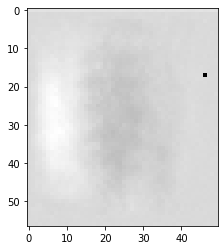

In [31]:
import torch
from torch.autograd import Variable
import numpy as np
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import torch.optim as optim
from torch import nn
import matplotlib.pyplot as plt


class Normal(object):
    def __init__(self, mu, sigma, log_sigma, v=None, r=None):
        self.mu = mu
        self.sigma = sigma  # either stdev diagonal itself, or stdev diagonal from decomposition
        self.logsigma = log_sigma
        dim = mu.get_shape()
        if v is None:
            v = torch.FloatTensor(*dim)
            if r is None:
                r = torch.FloatTensor(*dim)
                self.v = v
                self.r = r
                
                
class Encoder(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        super(Encoder, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, D_out)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        return F.relu(self.linear2(x))
    
    
class Decoder(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        super(Decoder, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, D_out)
    
    def forward(self, x):
        x = F.relu(self.linear1(x))
        return F.relu(self.linear2(x))
    
class VAE(torch.nn.Module):
    def __init__(self, encoder, decoder):
        super(VAE, self).__init__()
        self.latent_dim = 64
        self.encoder = encoder
        self.decoder = decoder
        self._enc_mu = torch.nn.Linear(100, self.latent_dim)
        self._enc_log_sigma = torch.nn.Linear(100, self.latent_dim)
    
    def _sample_latent(self, h_enc):
        """
        Return the latent normal sample z ~ N(mu, sigma^2)
        """
        mu = self._enc_mu(h_enc)
        log_sigma = self._enc_log_sigma(h_enc)
        sigma = torch.exp(log_sigma)
        std_z = torch.from_numpy(np.random.normal(0, 1, size=sigma.size())).float()
        
        self.z_mean = mu
        self.z_sigma = sigma
        return mu + sigma * Variable(std_z, requires_grad=False)  # Reparameterization trick
    
    def forward(self, state):
        h_enc = self.encoder(state)
        z = self._sample_latent(h_enc)
        return self.decoder(z)
    
def latent_loss(z_mean, z_stddev):
    mean_sq = z_mean * z_mean
    stddev_sq = z_stddev * z_stddev
    return 0.5 * torch.mean(mean_sq + stddev_sq - torch.log(stddev_sq) - 1)

input_dim = 57 * 50
batch_size = 32
encoder = Encoder(input_dim, 100, 100)
decoder = Decoder(64, 100, input_dim)
vae = VAE(encoder, decoder)
criterion = nn.MSELoss()

optimizer = optim.Adam(vae.parameters(), lr=0.001)
l = None
for epoch in tqdm(range(3000)):
    idxs, states, actions, returns, next_states, nonterminals, weights, masks = val_mem.sample(32)
    inputs =  Variable(states[:,:,14:-13,17:-17].reshape((32*4,57*50)).cpu())
    optimizer.zero_grad()
    dec = vae(inputs)
    ll = latent_loss(vae.z_mean, vae.z_sigma)
    loss = criterion(dec, inputs) + ll
    loss.backward()
    optimizer.step()
    l = loss.item()
    
    print(epoch, l)
    
plt.imshow(vae(inputs).data[0].numpy().reshape(57, 50), cmap='gray')
plt.show(block=True)

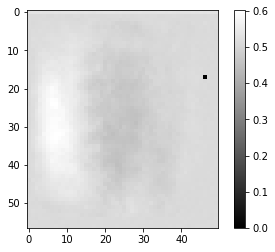

In [37]:
plt.imshow(vae(inputs).data[1].numpy().reshape(57, 50), cmap='gray')
plt.colorbar()

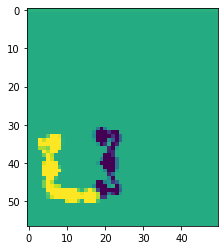

In [33]:
plt.imshow(inputs.data[1].numpy().reshape(57,50))

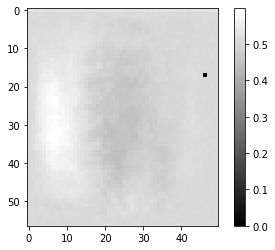

In [34]:
plt.imshow(vae(inputs).data[20].numpy().reshape(57, 50), cmap='gray')
plt.colorbar()

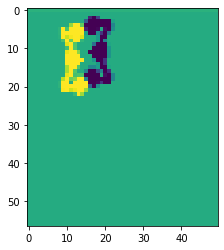

In [30]:
plt.imshow(inputs.data[20].numpy().reshape(57,50))

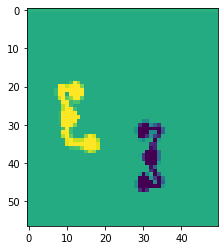

In [17]:
plt.imshow(inputs.data[20].numpy().reshape(57,50))

In [39]:
total_dataset = []

for state in state_list:
    check = state.cpu().detach().numpy()
    total_dataset.append(check)

In [40]:
total_dataset = np.array(total_dataset)

In [43]:
total_dataset.shape

(11994, 4, 84, 84)

In [53]:
X = np.reshape(total_dataset[:,0,14:-13,17:-17], (11994, 1, 57*50))

In [57]:
encoded_data = vae.encoder(torch.tensor(X)).cpu().detach().numpy()

In [61]:
np.reshape(encoded_data,(11994,64))

ValueError: cannot reshape array of size 1199400 into shape (11994,64)

In [58]:
from sklearn.cluster import KMeans

In [60]:
clusterer = KMeans(n_clusters=3)

In [ ]:
clusterer.fit(encoded_data)